In [1]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_exam import Gen_spec
from sim_engine import *
from spec_stats import Highest_density_region
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from C_full_fit import Gen_spec2, Chi_Squared
from C_sim_test import Gen_sim, F_lam_per_M
from prospect.models.transforms import logsfr_ratios_to_masses

import dynesty
from dynesty import plotting as dyplot
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
def Get_posterior(results, entry):
    sample = results.samples[:, entry]
    logwt = results.logwt
    logz = results.logz
    
    
    weight = np.exp(logwt - logz[-1])

    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(sample.T, q, weights=weight)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(sample, bins=bins, weights=weight,
                        range=np.sort(span))
    n = norm_kde(n, 10.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

In [3]:
specz = 1.25
lages = [0,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9]

tuniv = Oldest_galaxy(specz)
nbins = len(lages) - 1

tbinmax = (tuniv * 0.85) * 1e9
lim1, lim2 = 7.4772, 8.0
agelims = [0,lim1] + np.linspace(lim2,np.log10(tbinmax),nbins-2).tolist() + [np.log10(tuniv*1e9)]
agebins = np.array([agelims[:-1], agelims[1:]]).T

LBT = (10**agebins.T[1][::-1][0] - 10**agebins.T[0][::-1])*1E-9

In [4]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)
sp.params['compute_light_ages'] = True

sp.params['dust2'] =0.2
sp.params['dust1'] =0.2

tab_sfh = np.array([0.9, 0.3, 0.025, 0.01, 0.01, 0.001, 0.00001, 0.0002, 0.002, 0.0001])
tab_Z = np.array([0.2, 1.0, 1.1, 1.0, 0.95, 0.9, 1.1, 1.0, 0.9, 0.8])*0.019


sp.set_tabular_sfh(LBT,tab_sfh,Z = tab_Z )

lwa_td = sp.get_mags(tage = 4.25, bands=['sdss_g'])

sp.params['compute_light_ages'] = False


# Compare bounding method for tab to delay

In [77]:
## logL
multi_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*multi**') if 'lwa' not in os.path.basename(fn)]
balls_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*balls**') if 'lwa' not in os.path.basename(fn)]
single_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*single**') if 'lwa' not in os.path.basename(fn)]
cubes_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*cubes**') if 'lwa' not in os.path.basename(fn)]

mL = []
bL = []
sL = []
cL = []

for i in range(len(multi_list)):
    dres = np.load(multi_list[i]).item()
    mL.append(dres.logl[-1])

for i in range(len(balls_list)):
    dres = np.load(balls_list[i]).item()
    bL.append(dres.logl[-1])

for i in range(len(single_list)):
    dres = np.load(single_list[i]).item()
    sL.append(dres.logl[-1])
    
for i in range(len(cubes_list)):
    dres = np.load(cubes_list[i]).item()
    cL.append(dres.logl[-1])

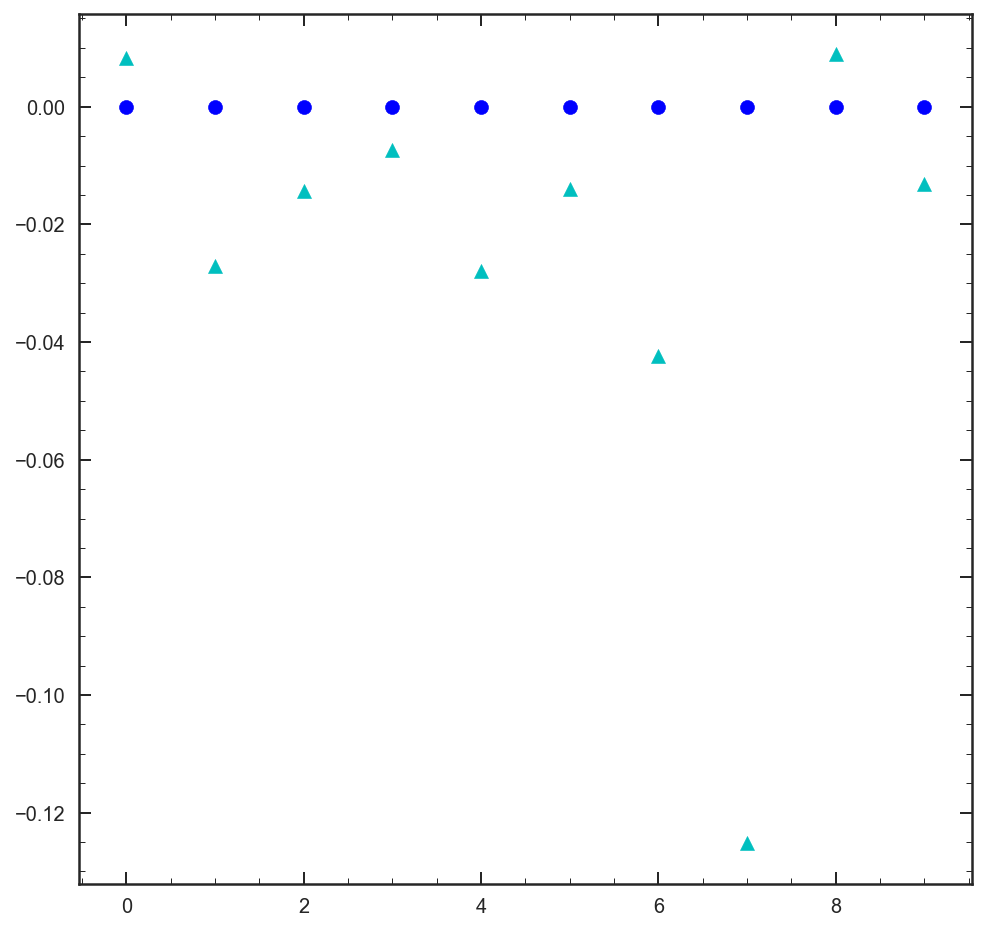

In [86]:
plt.figure(figsize=[8,8])
plt.scatter(range(len(mL)),np.abs(mL) - np.abs(mL),color='b', marker = 'o')
# plt.scatter(range(len(bL)),np.abs(bL) - np.abs(mL),color='r', marker = 'p')
plt.scatter(range(len(sL)),np.abs(sL) - np.abs(mL),color='c', marker = '^')
# plt.scatter(range(len(cL)),np.abs(cL) - np.abs(mL),color='k', marker = '*')

# plt.plot([-155,-120],[-155,-120])

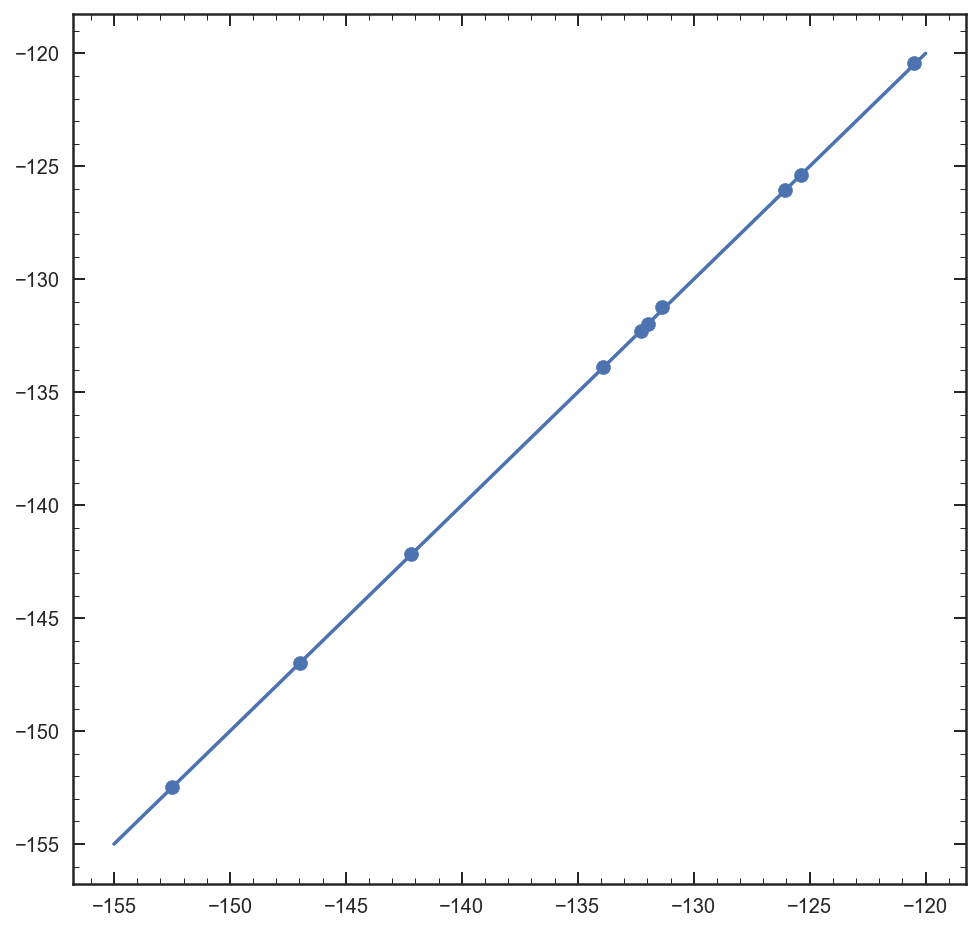

In [89]:
plt.figure(figsize=[8,8])
plt.scatter(mL,sL)
plt.plot([-155,-120],[-155,-120])

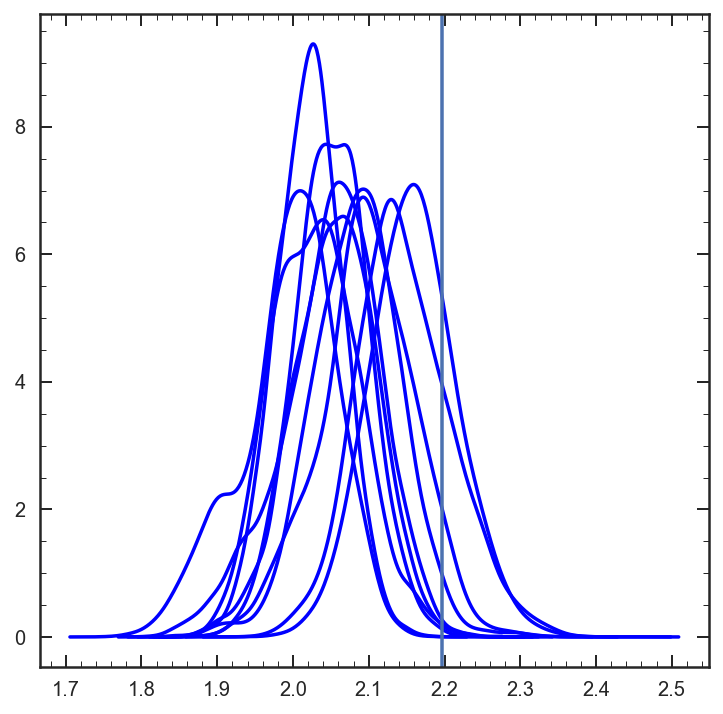

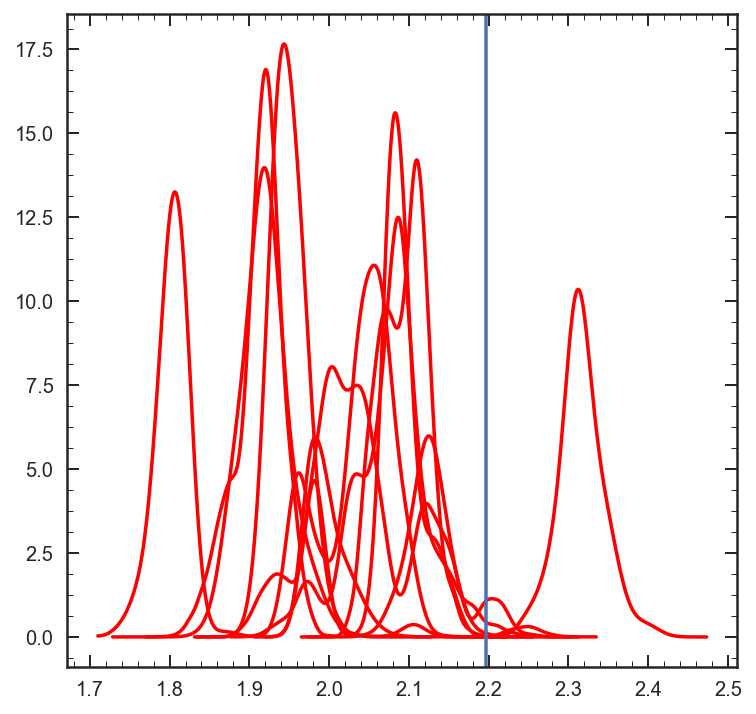

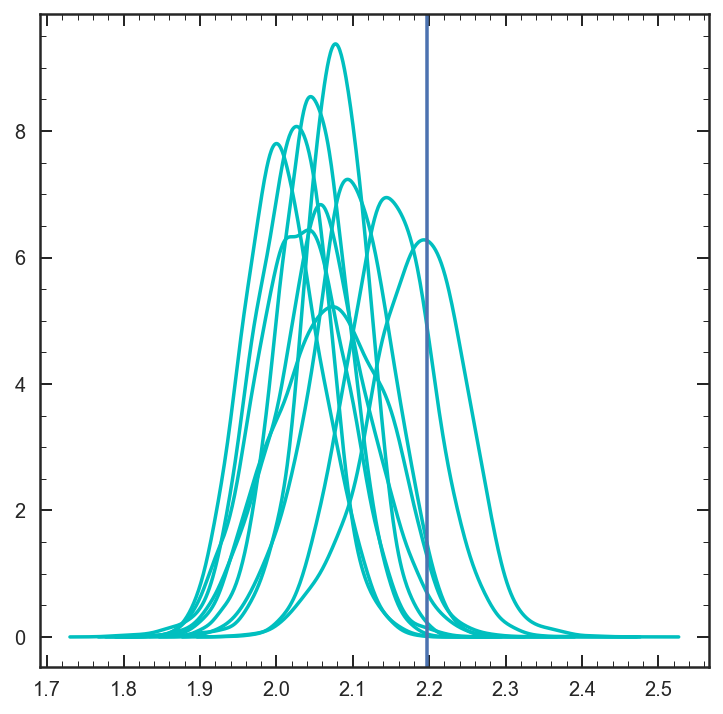

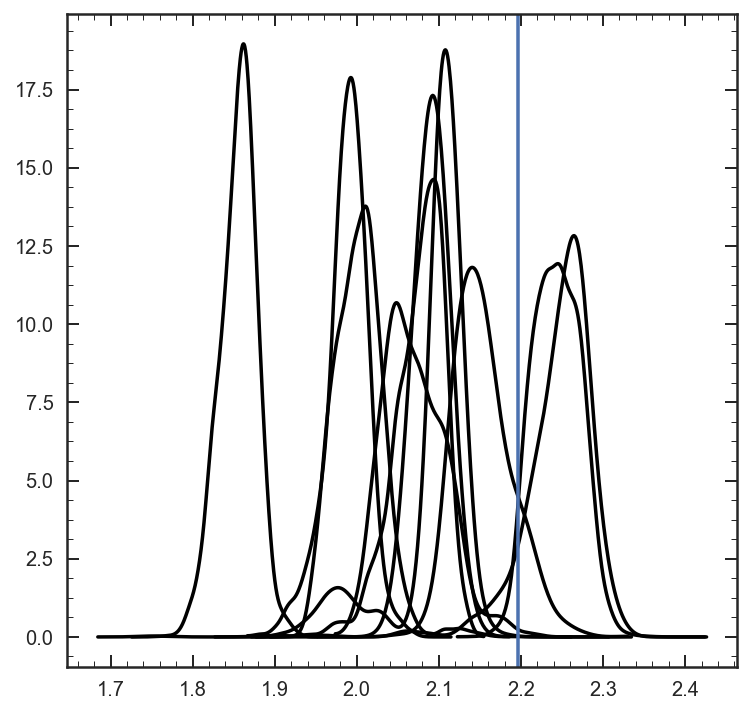

In [141]:
plt.figure(figsize=[6,6])
for i in range(10):
    mlwa = np.load('../data/out_dict/sim_test_tab_to_delay_multi_{0}_lwa.npy'.format(i+1))
    
    dres = np.load('../data/out_dict/sim_test_tab_to_delay_multi_{0}.npy'.format(i+1)).item()
    dres.samples[:,1] = mlwa
    m,Pm = Get_posterior(dres.samples[:,1], dres.logwt, dres.logz)
    
    plt.plot(m,Pm,'b')
plt.axvline(lwa_td)
    
plt.figure(figsize=[6,6])    
for i in range(10):
    blwa = np.load('../data/out_dict/sim_test_tab_to_delay_balls_{0}_lwa.npy'.format(i+1)) 
    
    dres = np.load('../data/out_dict/sim_test_tab_to_delay_balls_{0}.npy'.format(i+1)).item()
    dres.samples[:,1] = blwa
    b,Pb = Get_posterior(dres.samples[:,1], dres.logwt, dres.logz)
    
    plt.plot(b,Pb,'r')

plt.axvline(lwa_td)

plt.figure(figsize=[6,6])
for i in range(10):
    slwa = np.load('../data/out_dict/sim_test_tab_to_delay_single_{0}_lwa.npy'.format(i+1)) 
    
    dres = np.load('../data/out_dict/sim_test_tab_to_delay_single_{0}.npy'.format(i+1)).item()
    dres.samples[:,1] = slwa
    s,Ps = Get_posterior(dres.samples[:,1], dres.logwt, dres.logz)

    plt.plot(s,Ps,'c')
plt.axvline(lwa_td)

plt.figure(figsize=[6,6])
for i in range(10):
    clwa = np.load('../data/out_dict/sim_test_tab_to_delay_cubes_{0}_lwa.npy'.format(i+1)) 
    
    dres = np.load('../data/out_dict/sim_test_tab_to_delay_cubes_{0}.npy'.format(i+1)).item()
    dres.samples[:,1] = clwa
    c,Pc = Get_posterior(dres.samples[:,1], dres.logwt, dres.logz)
    
    plt.plot(c,Pc,'k')
plt.axvline(lwa_td)

# Compare bounding method for delay to tab

In [62]:
## logL

mL = []
# bL = []
# sL = []
# cL = []
wL = []

for i in range(1,11,1):
    bfit = np.load('../data/bestfits/sim_test_delay_to_tab_continuity_prior_multi_{0}_bfit.npy'.format(i))
    mL.append(bfit[-1])

#     dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_balls_{0}.npy'.format(i)).item()
#     bL.append(dres.logl[-1])

#     dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_single_{0}.npy'.format(i)).item()
#     sL.append(dres.logl[-1])
    
#     dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_cubes_{0}.npy'.format(i)).item()
#     cL.append(dres.logl[-1])
    
    bfit = np.load('../data/bestfits/sim_test_delay_to_tab_continuity_prior_multi_metal_{0}_bfit.npy'.format(i))
    wL.append(bfit[-1])
    

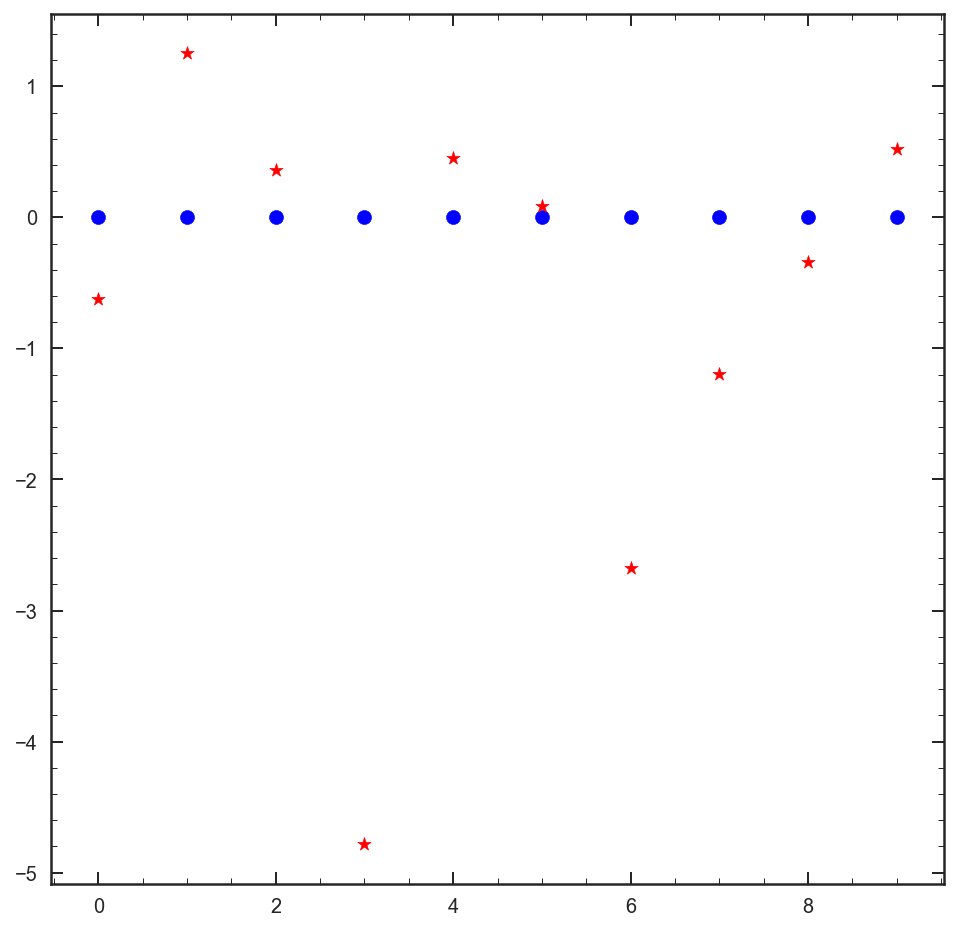

In [63]:
plt.figure(figsize=[8,8])
plt.scatter(range(len(mL)),np.abs(mL) - np.abs(mL),color='b', marker = 'o')
# plt.scatter(range(len(bL)),np.abs(bL) - np.abs(mL),color='r', marker = 'p')
# plt.scatter(range(len(sL)),np.abs(sL) - np.abs(mL),color='c', marker = '^')
# plt.scatter(range(len(cL)),np.abs(cL) - np.abs(mL),color='k', marker = '*')
plt.scatter(range(len(mL)),np.abs(wL) - np.abs(mL),color='r', marker = '*')

# plt.plot([-155,-120],[-155,-120])

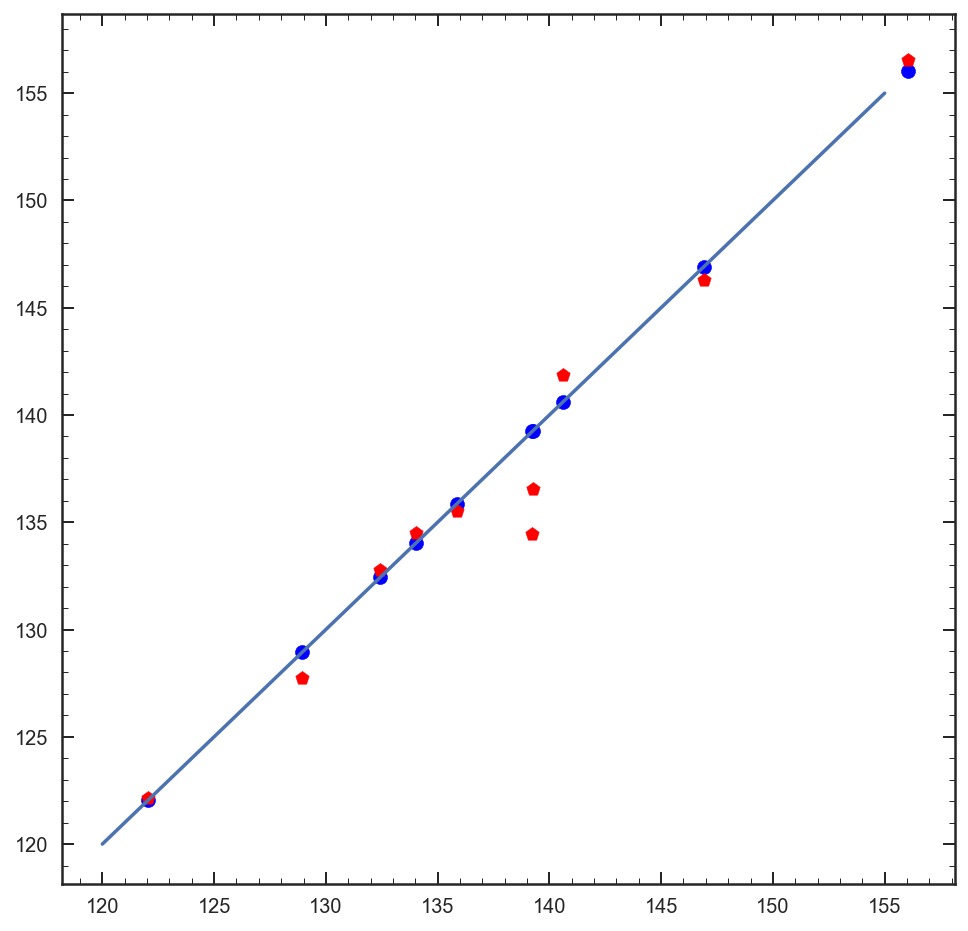

In [64]:
plt.figure(figsize=[8,8])
plt.scatter(np.abs(mL),np.abs(mL),color='b', marker = 'o')
plt.scatter(np.abs(mL),np.abs(wL),color='r', marker = 'p')
# plt.scatter(np.abs(mL),np.abs(sL),color='c', marker = '^')
# plt.scatter(np.abs(mL),np.abs(cL),color='k', marker = '*')

plt.plot([155,120],[155,120])

In [65]:
mL

[-146.9117080182006,
 -140.59396823106863,
 -132.43091572558595,
 -139.2342668263697,
 -134.05402172644446,
 -122.05713906630405,
 -139.24840331949792,
 -128.94816429313863,
 -135.858396540712,
 -156.0352663974574]

In [66]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau=0.1, dust_type = 1)
sp.params['compute_light_ages'] = True

sp.params['dust2'] =0.2
sp.params['dust1'] =0.2
sp.params['tau'] =0.3
sp.params['logzsol'] = np.log10(0.8)

lwa_dt = sp.get_mags(tage = 4.5, bands =['sdss_g'])
       
sp.params['compute_light_ages'] = False

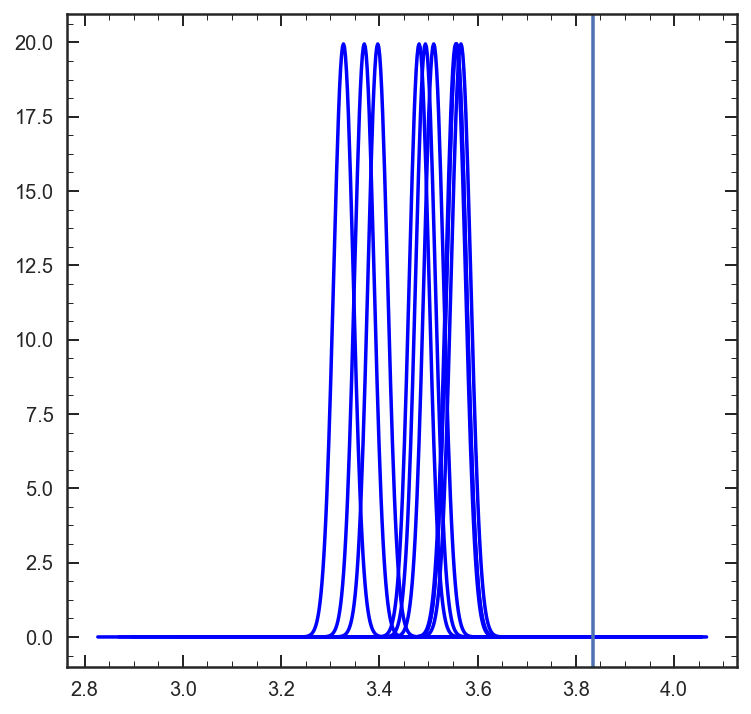

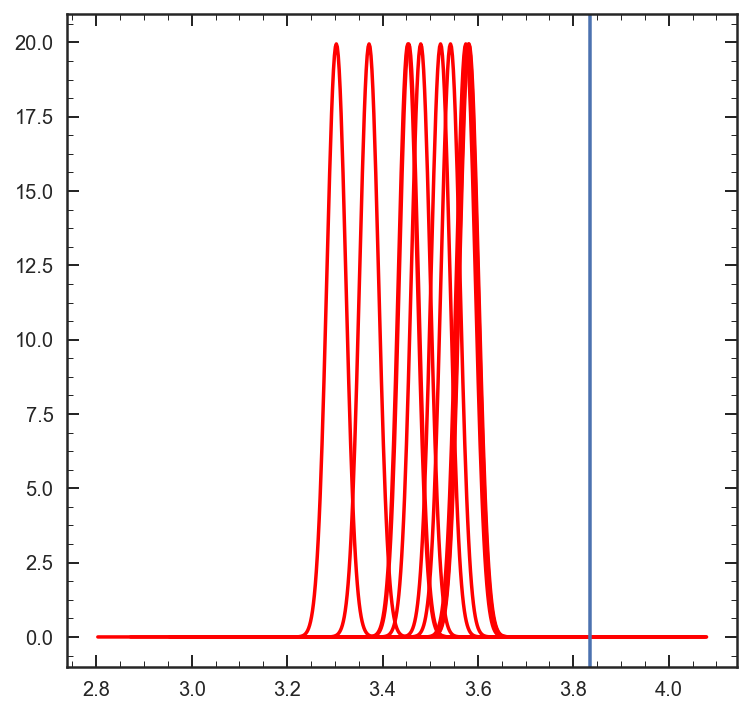

In [71]:
plt.figure(figsize=[6,6])
for i in range(10): 
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_continuity_prior_multi_{0}_Plwa.npy'.format(i+1))
    plt.plot(m,Pm,'b')
plt.axvline(lwa_dt)
  
    
plt.figure(figsize=[6,6])
for i in range(10):
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_continuity_prior_multi_metal_{0}_Plwa.npy'.format(i+1))

    plt.plot(m,Pm,'r')
plt.axvline(lwa_dt)
    
# plt.figure(figsize=[6,6])    
# for i in range(10):
#     blwa = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_balls_{0}_lwa.npy'.format(i+1)) 
    
#     dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_balls_{0}.npy'.format(i+1)).item()
#     dres.samples[:,1] = blwa
#     b,Pb = Get_posterior(dres.samples[:,1], dres.logwt, dres.logz)
    
#     plt.plot(b,Pb,'r')

# plt.axvline(lwa_dt)

# plt.figure(figsize=[6,6])
# for i in range(10):
#     slwa = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_single_{0}_lwa.npy'.format(i+1)) 
    
#     dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_single_{0}.npy'.format(i+1)).item()
#     dres.samples[:,1] = slwa
#     s,Ps = Get_posterior(dres.samples[:,1], dres.logwt, dres.logz)

#     plt.plot(s,Ps,'c')
# plt.axvline(lwa_dt)

# plt.figure(figsize=[6,6])
# for i in range(10):
#     clwa = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_cubes_{0}_lwa.npy'.format(i+1)) 
    
#     dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_cubes_{0}.npy'.format(i+1)).item()
#     dres.samples[:,1] = clwa
#     c,Pc = Get_posterior(dres.samples[:,1], dres.logwt, dres.logz)
    
#     plt.plot(c,Pc,'k')
# plt.axvline(lwa_dt)

# Compare td spec_fits

In [110]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)
sp.params['dust2'] =0.2
sp.params['dust1'] =0.2

tab_sfh = np.array([0.9, 0.3, 0.025, 0.01, 0.01, 0.001, 0.00001, 0.0002, 0.002, 0.0001])
tab_Z = np.array([0.2, 1.0, 1.1, 1.0, 0.95, 0.9, 1.1, 1.0, 0.9, 0.8])*0.019

sp.set_tabular_sfh(LBT,tab_sfh, Z = tab_Z )

wave1, flux1 = sp.get_spectrum(tage = 4.25, peraa = True)

mass_perc1 = sp.stellar_mass
 
D_l = cosmo.luminosity_distance(specz).value # in Mpc
conv = 3.086E24
lsol_to_fsol = 3.839E33

mass_transform = (10**11 / mass_perc1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

In [126]:
# multi_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*multi**') if 'lwa' not in os.path.basename(fn)]
# balls_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*balls**') if 'lwa' not in os.path.basename(fn)]
# single_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*single**') if 'lwa' not in os.path.basename(fn)]
# cubes_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*cubes**') if 'lwa' not in os.path.basename(fn)]

# sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau=0.1, dust_type = 1)

# # mL = []
# # bL = []
# # sL = []
# # cL = []

# for i in range(len(multi_list)):
#     dres = np.load(multi_list[i]).item()
#     bfZ, bft, bftau, bfz, bfd, bflm = dres.samples[-1]

#     sp.params['dust2'] = bfd
#     sp.params['dust1'] = bfd
#     sp.params['tau'] = bftau
#     sp.params['logzsol'] = np.log10(bfZ)
#     wave, flux = sp.get_spectrum(tage = bft, peraa = True)

#     D_l = cosmo.luminosity_distance(bfz).value # in Mpc
#     MT = (10**bflm * lsol_to_fsol) / (4 * np.pi * (D_l*conv)**2)

#     plt.figure(figsize=[15,5])
#     plt.plot(np.log10(wave1), flux1 * mass_transform,'k')
#     plt.plot(np.log10(wave), flux * MT,'b')
#     plt.title(dres.logl[-1])
#     plt.xlim(2.8,5)

# for i in range(len(balls_list)):
#     dres = np.load(balls_list[i]).item()
#     bfZ, bft, bftau, bfz, bfd, bflm = dres.samples[-1]

#     sp.params['dust2'] = bfd
#     sp.params['dust1'] = bfd
#     sp.params['tau'] = bftau
#     sp.params['logzsol'] = np.log10(bfZ)
#     wave, flux = sp.get_spectrum(tage = bft, peraa = True)

#     D_l = cosmo.luminosity_distance(bfz).value # in Mpc
#     MT = (10**bflm * lsol_to_fsol) / (4 * np.pi * (D_l*conv)**2)

#     plt.figure(figsize=[15,5])
#     plt.plot(np.log10(wave1), flux1 * mass_transform,'k')
#     plt.plot(np.log10(wave), flux * MT,'r')
#     plt.title(dres.logl[-1])
#     plt.xlim(2.8,5)
    
# for i in range(len(single_list)):
#     dres = np.load(single_list[i]).item()
#     bfZ, bft, bftau, bfz, bfd, bflm = dres.samples[-1]

#     sp.params['dust2'] = bfd
#     sp.params['dust1'] = bfd
#     sp.params['tau'] = bftau
#     sp.params['logzsol'] = np.log10(bfZ)
#     wave, flux = sp.get_spectrum(tage = bft, peraa = True)

#     D_l = cosmo.luminosity_distance(bfz).value # in Mpc
#     MT = (10**bflm * lsol_to_fsol) / (4 * np.pi * (D_l*conv)**2)

#     plt.figure(figsize=[15,5])
#     plt.plot(np.log10(wave1), flux1 * mass_transform,'k')
#     plt.plot(np.log10(wave), flux * MT,'c')
#     plt.title(dres.logl[-1])
#     plt.xlim(2.8,5)
    
# for i in range(len(cubes_list)):
#     dres = np.load(cubes_list[i]).item()
#     bfZ, bft, bftau, bfz, bfd, bflm = dres.samples[-1]

#     sp.params['dust2'] = bfd
#     sp.params['dust1'] = bfd
#     sp.params['tau'] = bftau
#     sp.params['logzsol'] = np.log10(bfZ)
#     wave, flux = sp.get_spectrum(tage = bft, peraa = True)

#     D_l = cosmo.luminosity_distance(bfz).value # in Mpc
#     MT = (10**bflm * lsol_to_fsol) / (4 * np.pi * (D_l*conv)**2)

#     plt.figure(figsize=[15,5])
#     plt.plot(np.log10(wave1), flux1 * mass_transform,'k')
#     plt.plot(np.log10(wave), flux * MT,'g')
#     plt.title(dres.logl[-1])
#     plt.xlim(2.8,5)

# Compare dt spec_fits

In [72]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau=0.1, dust_type = 1)
sp.params['dust2'] =0.2
sp.params['dust1'] =0.2
sp.params['tau'] =0.3
sp.params['logzsol'] = np.log10(0.8)

wave2, flux2 = sp.get_spectrum(tage = 4.25, peraa = True)

mass_perc2 = sp.stellar_mass

D_l = cosmo.luminosity_distance(specz).value # in Mpc
conv = 3.086E24
lsol_to_fsol = 3.839E33

mass_transform = 10**11* lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

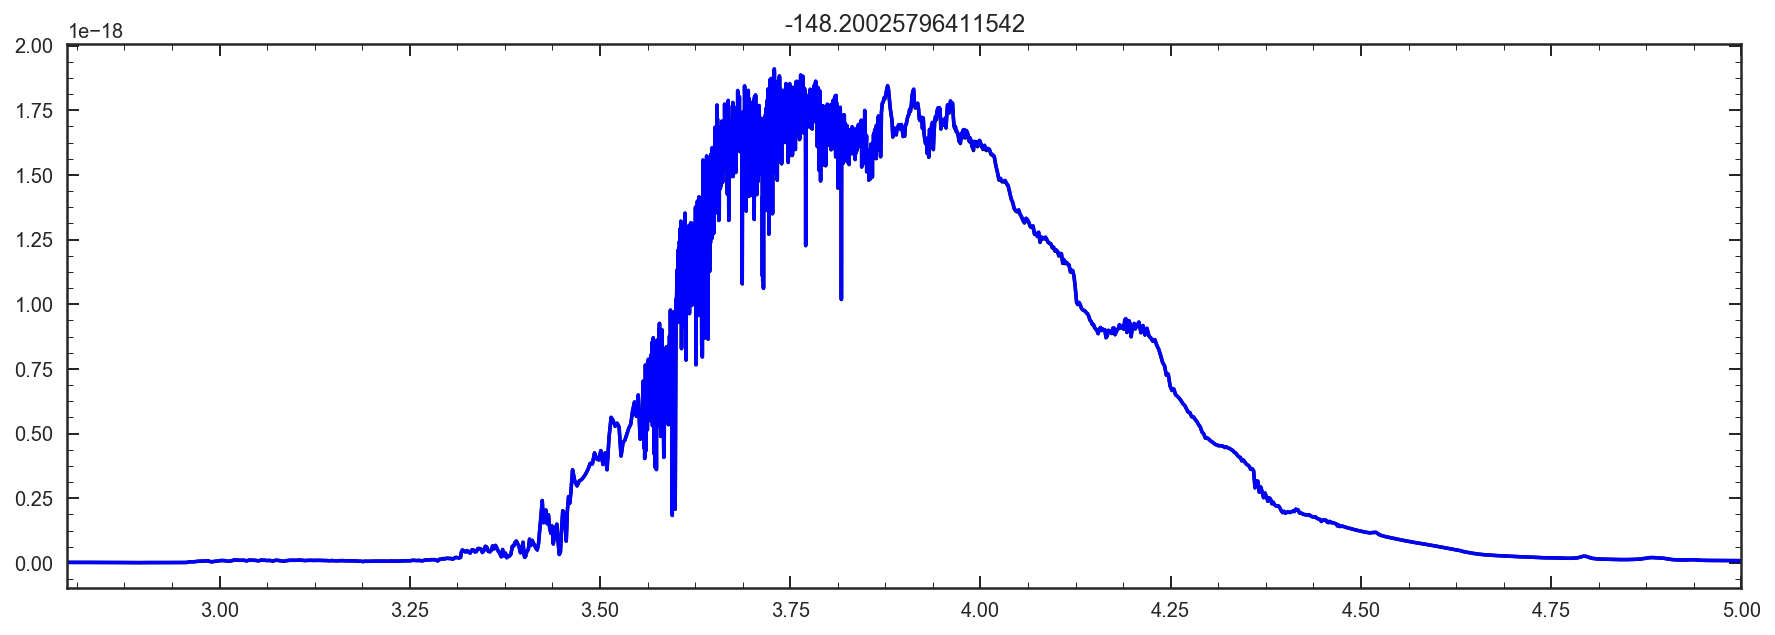

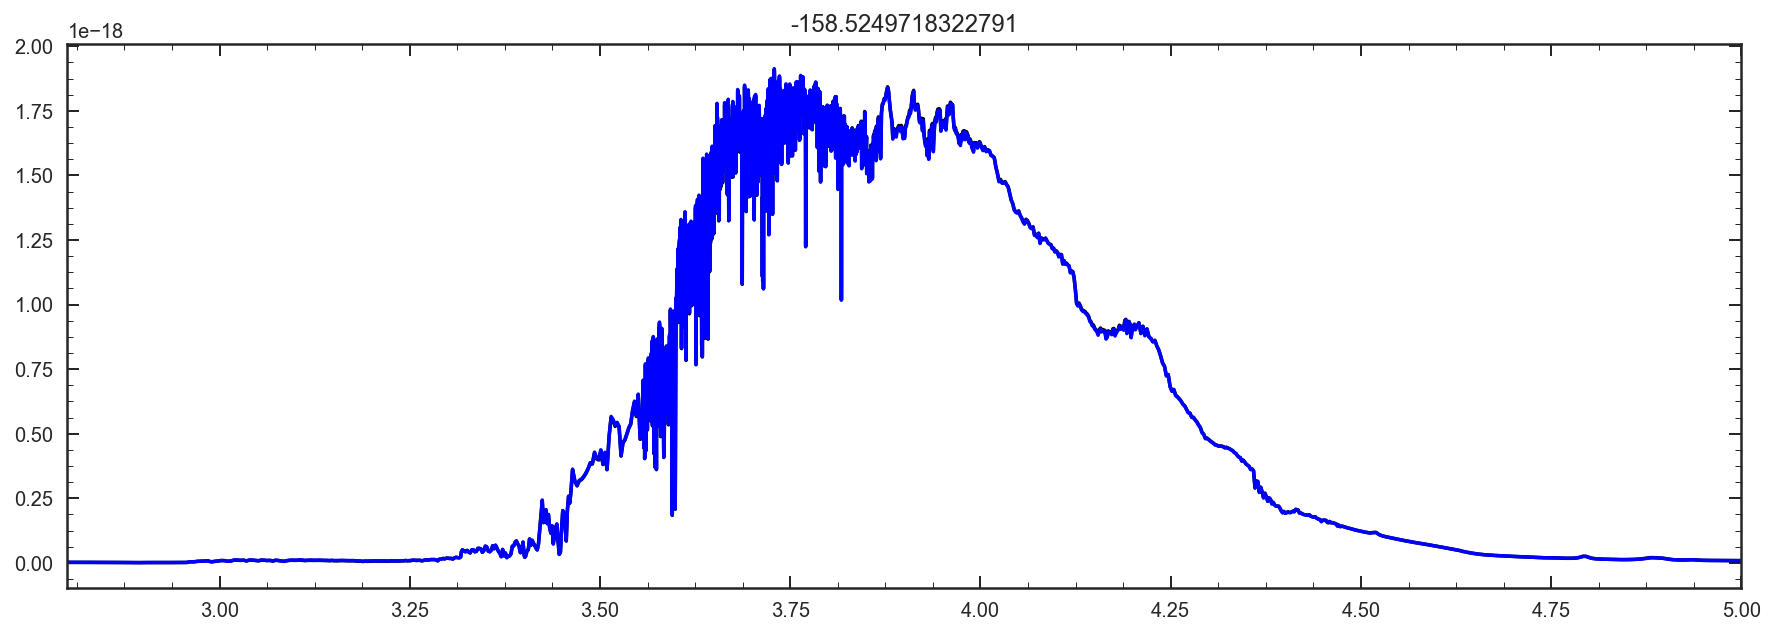

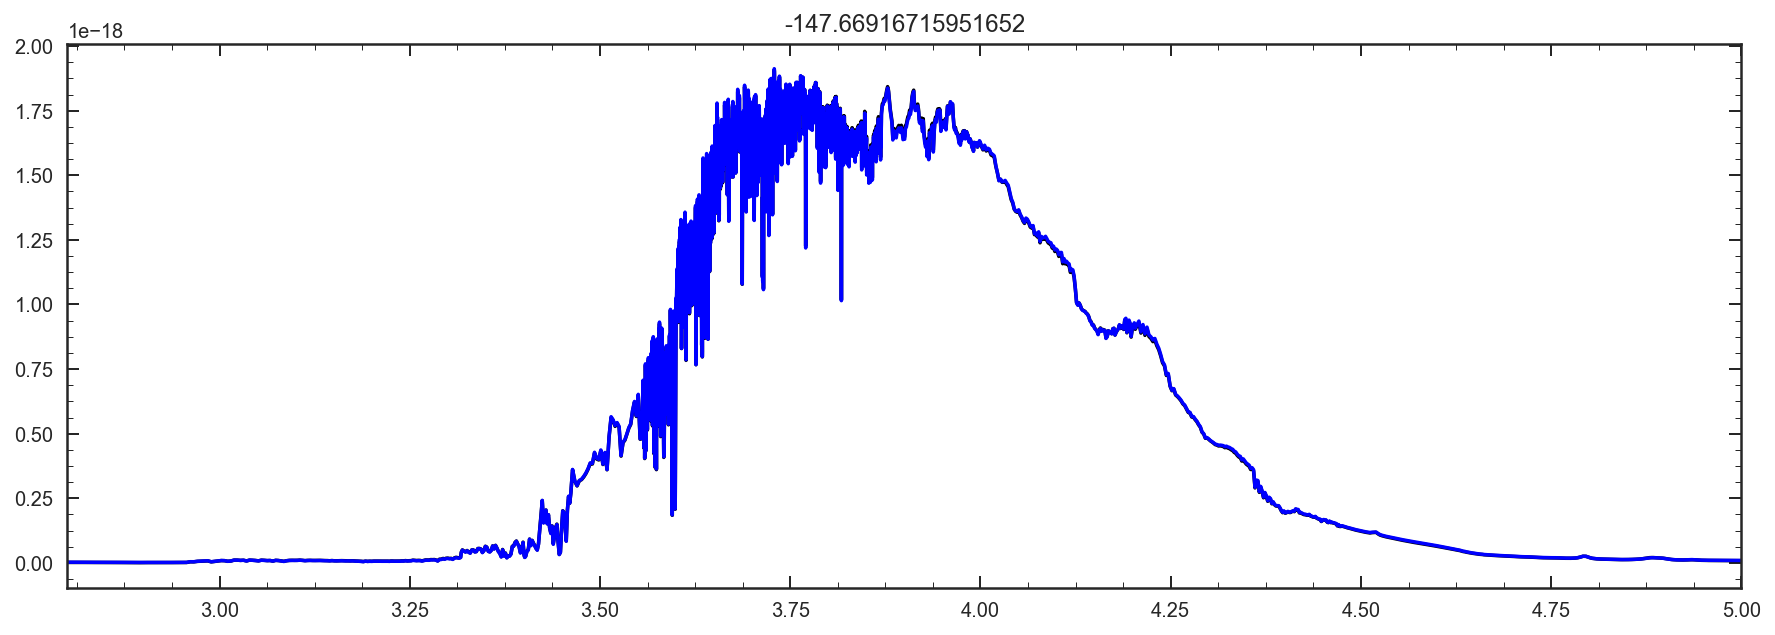

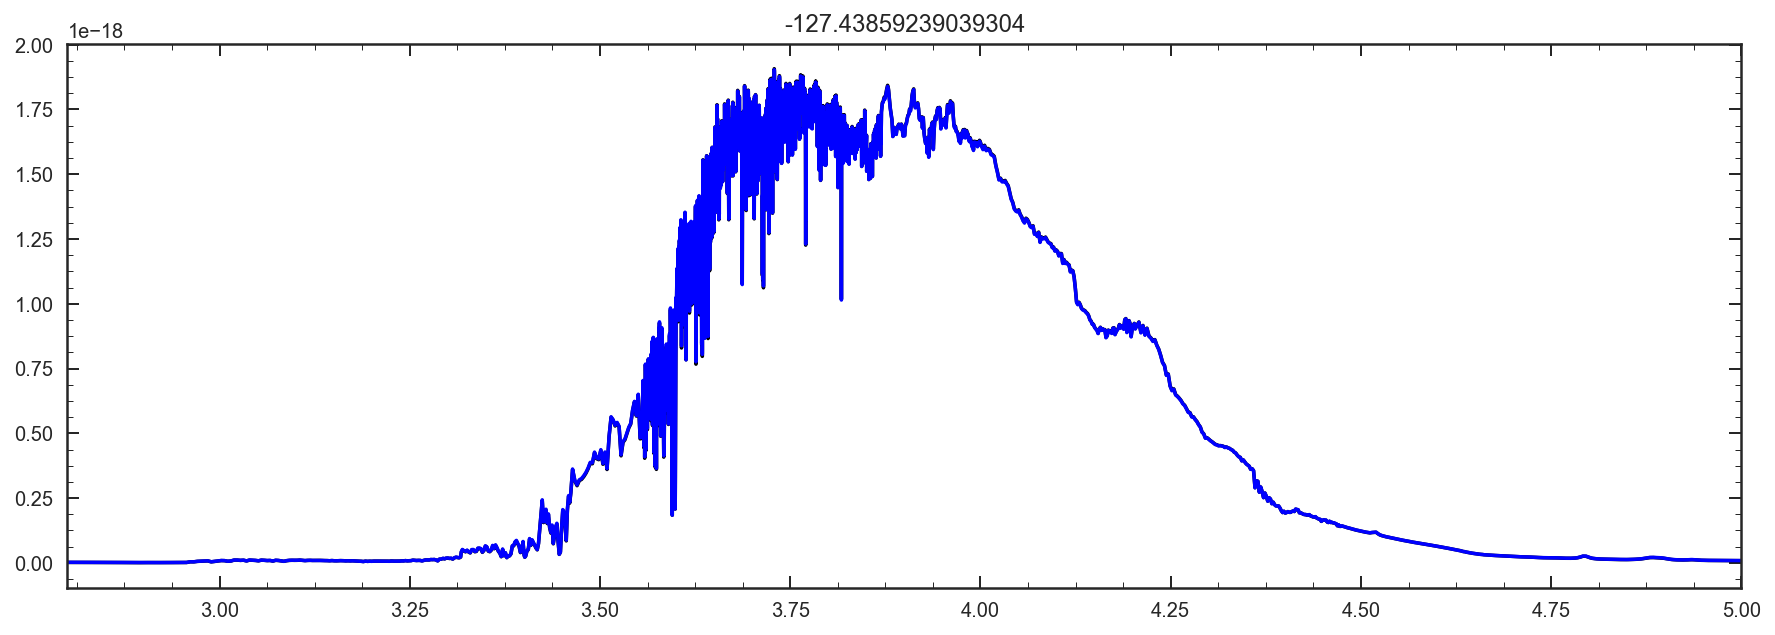

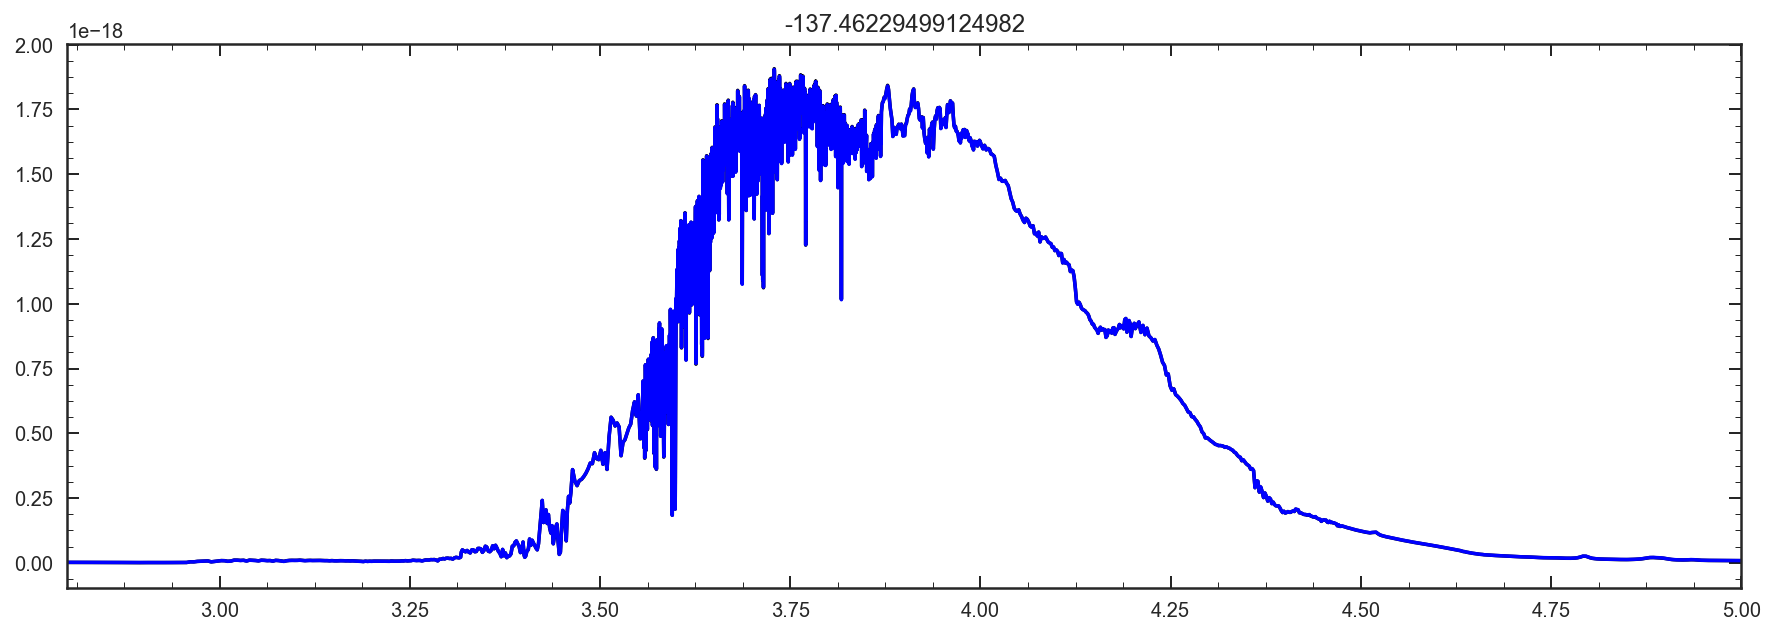

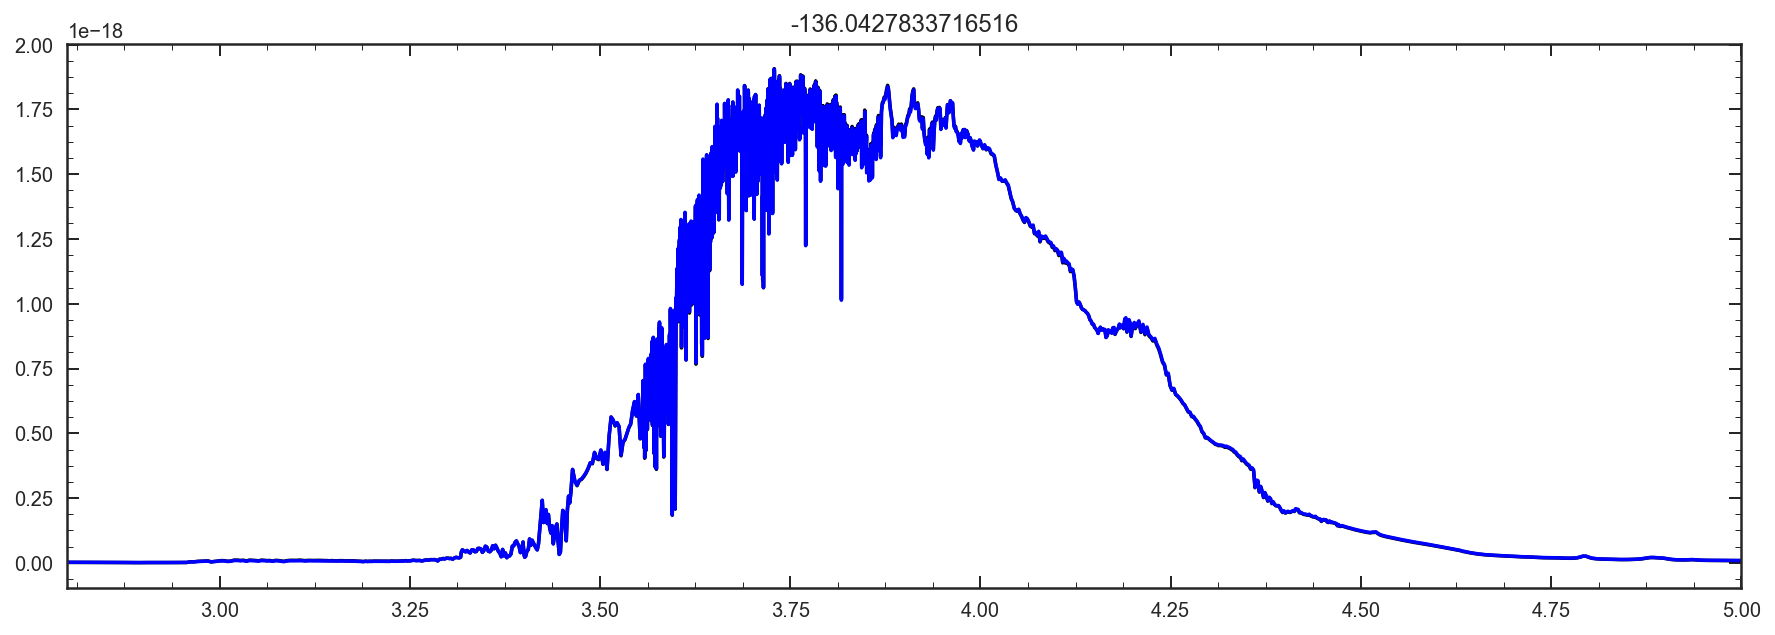

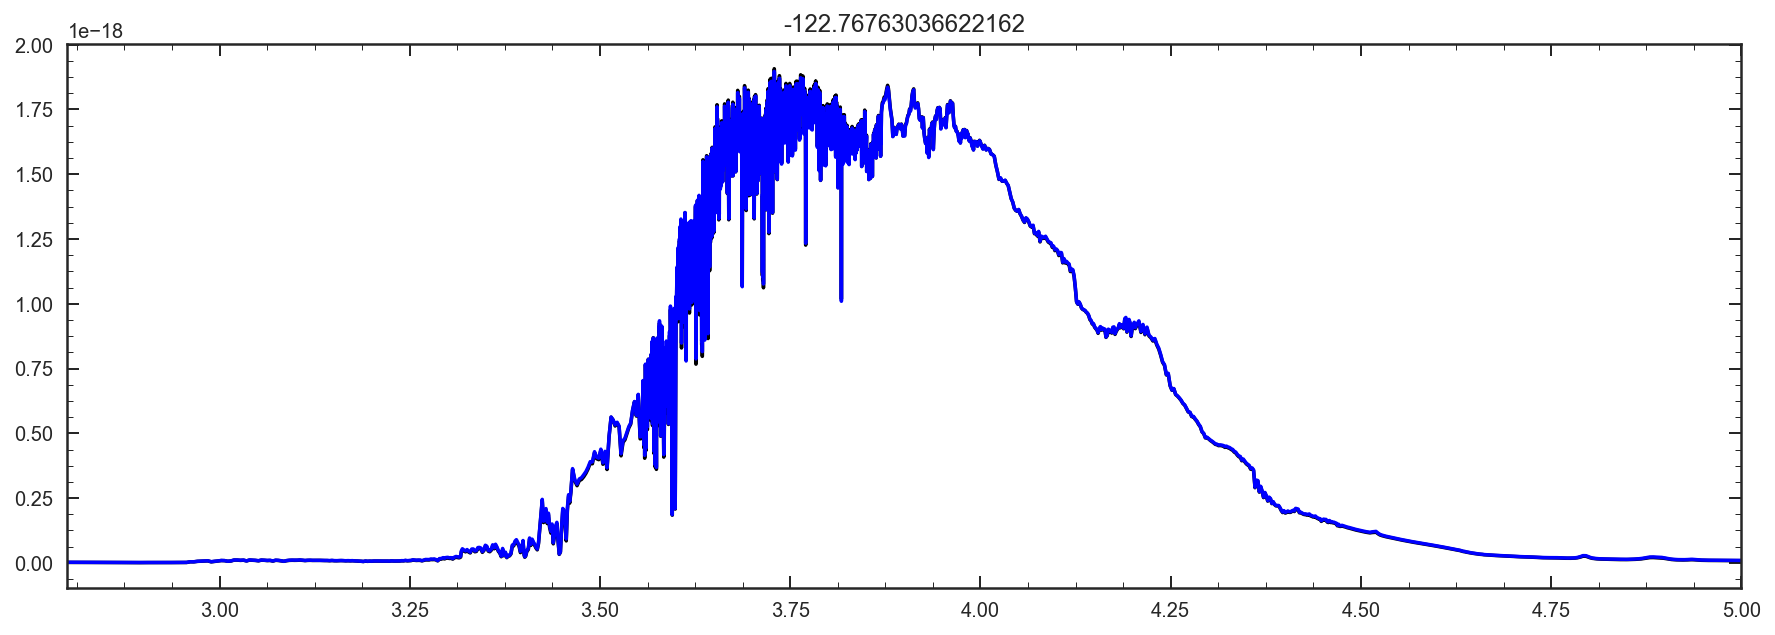

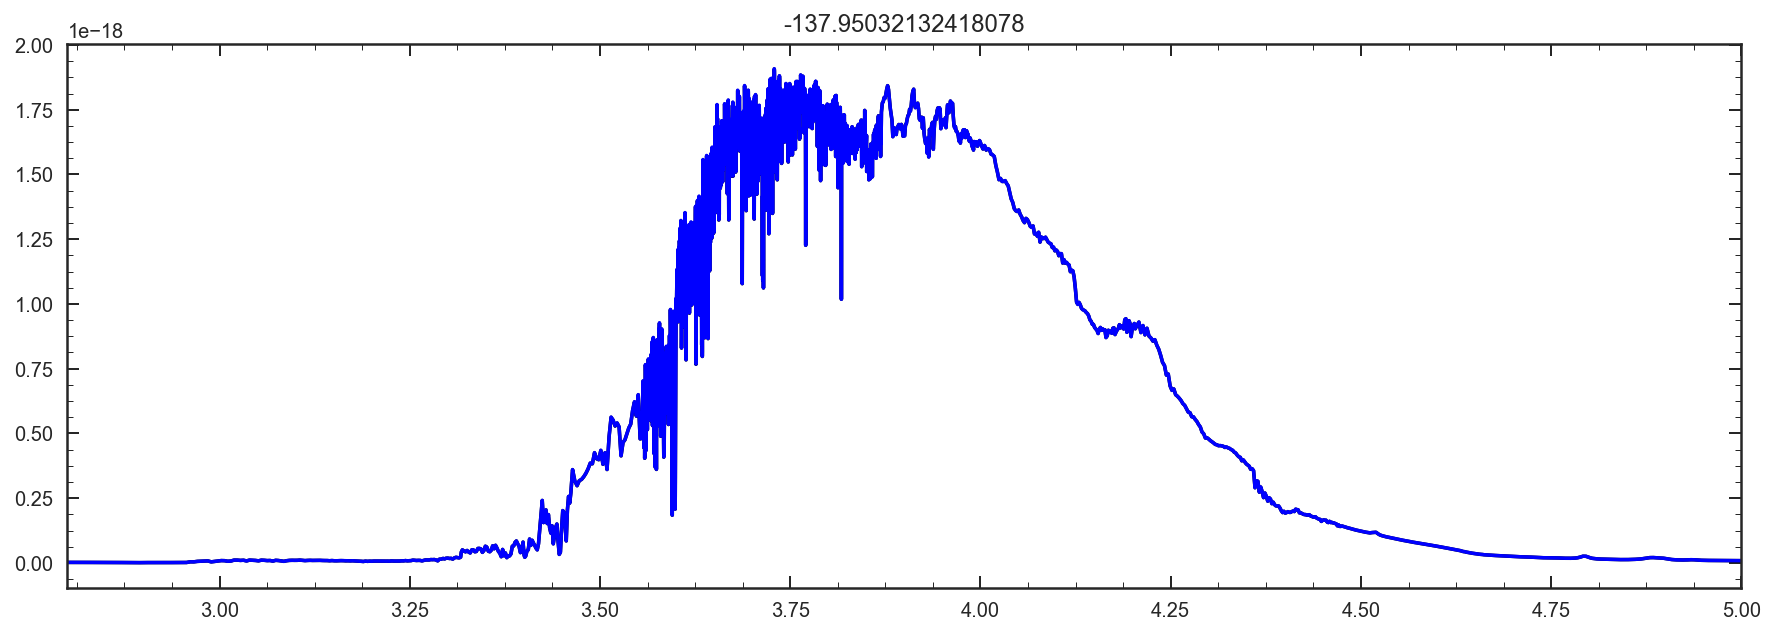

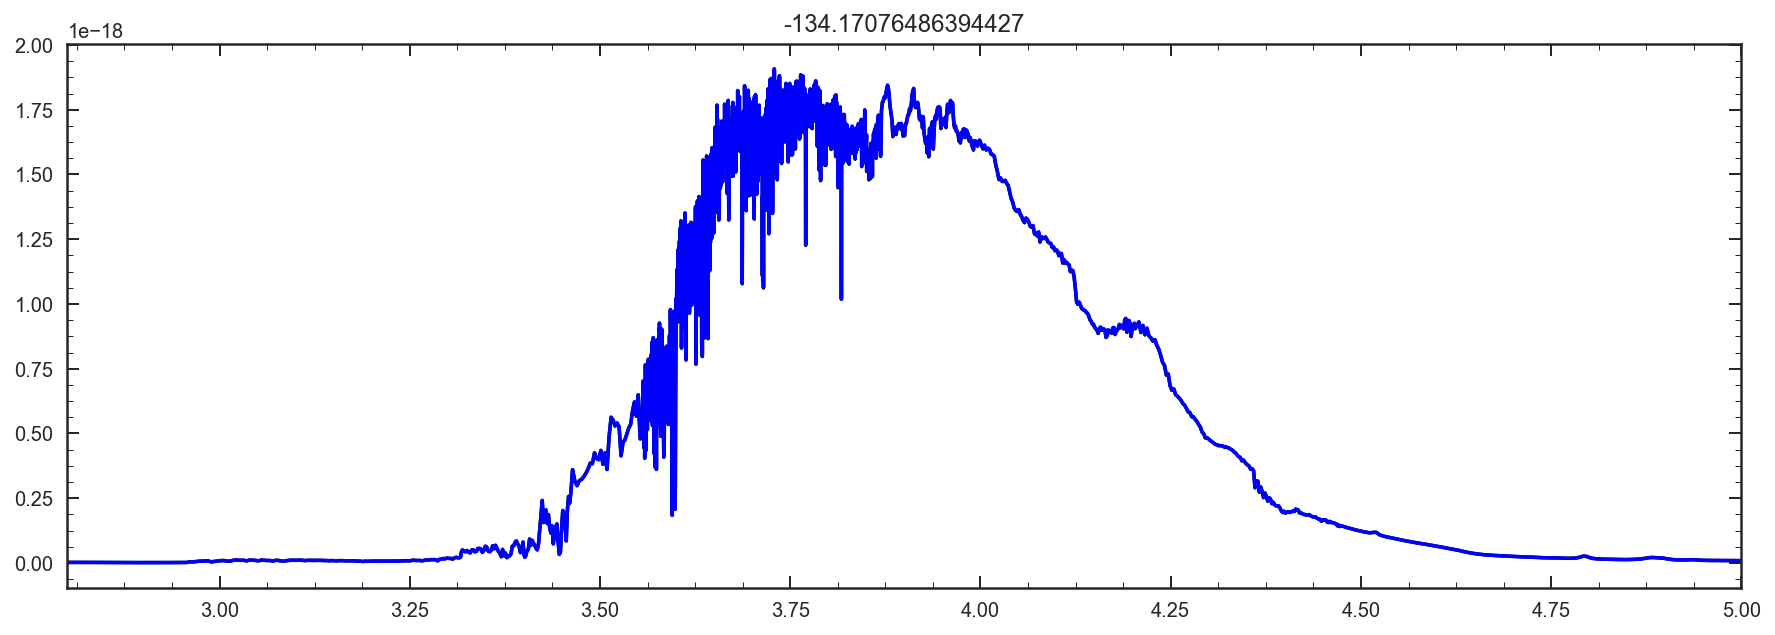

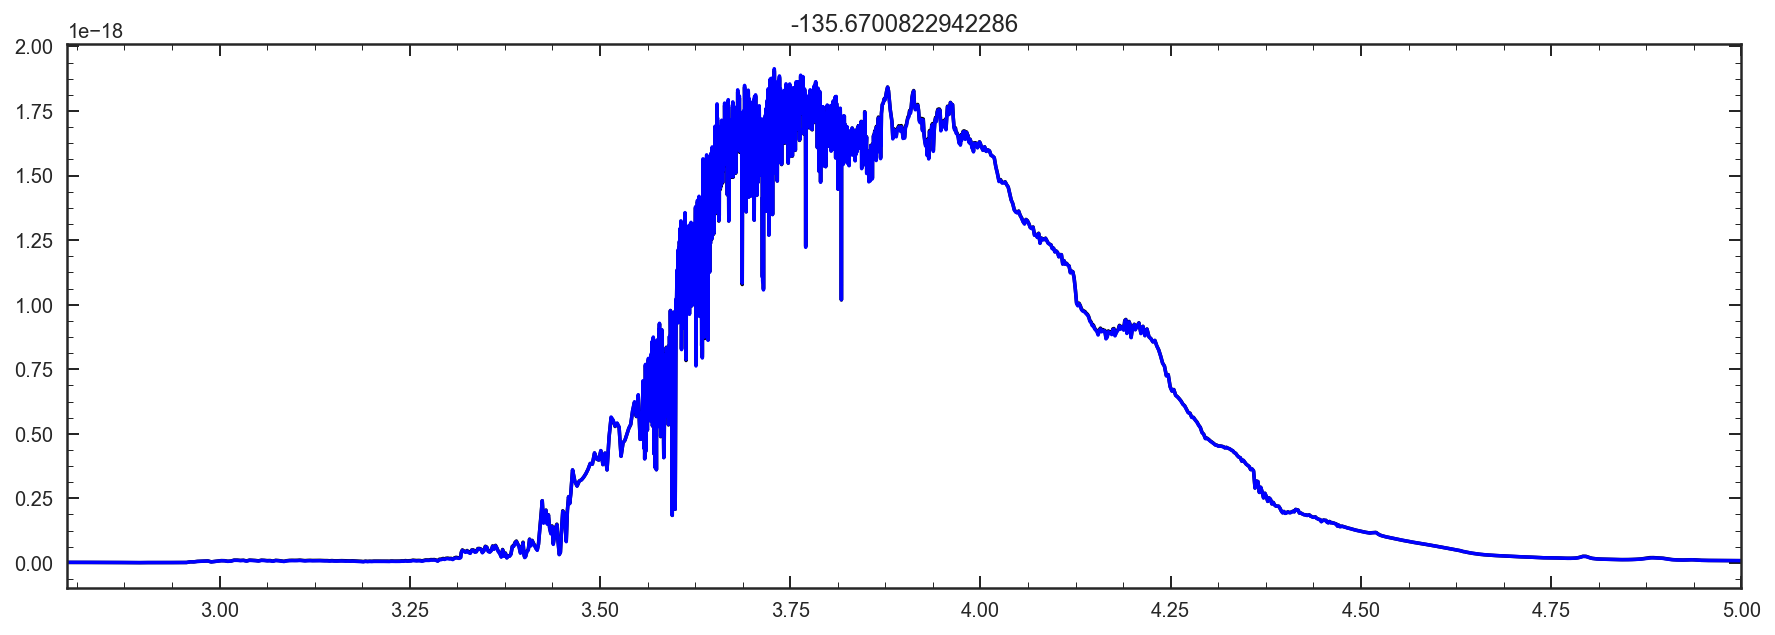

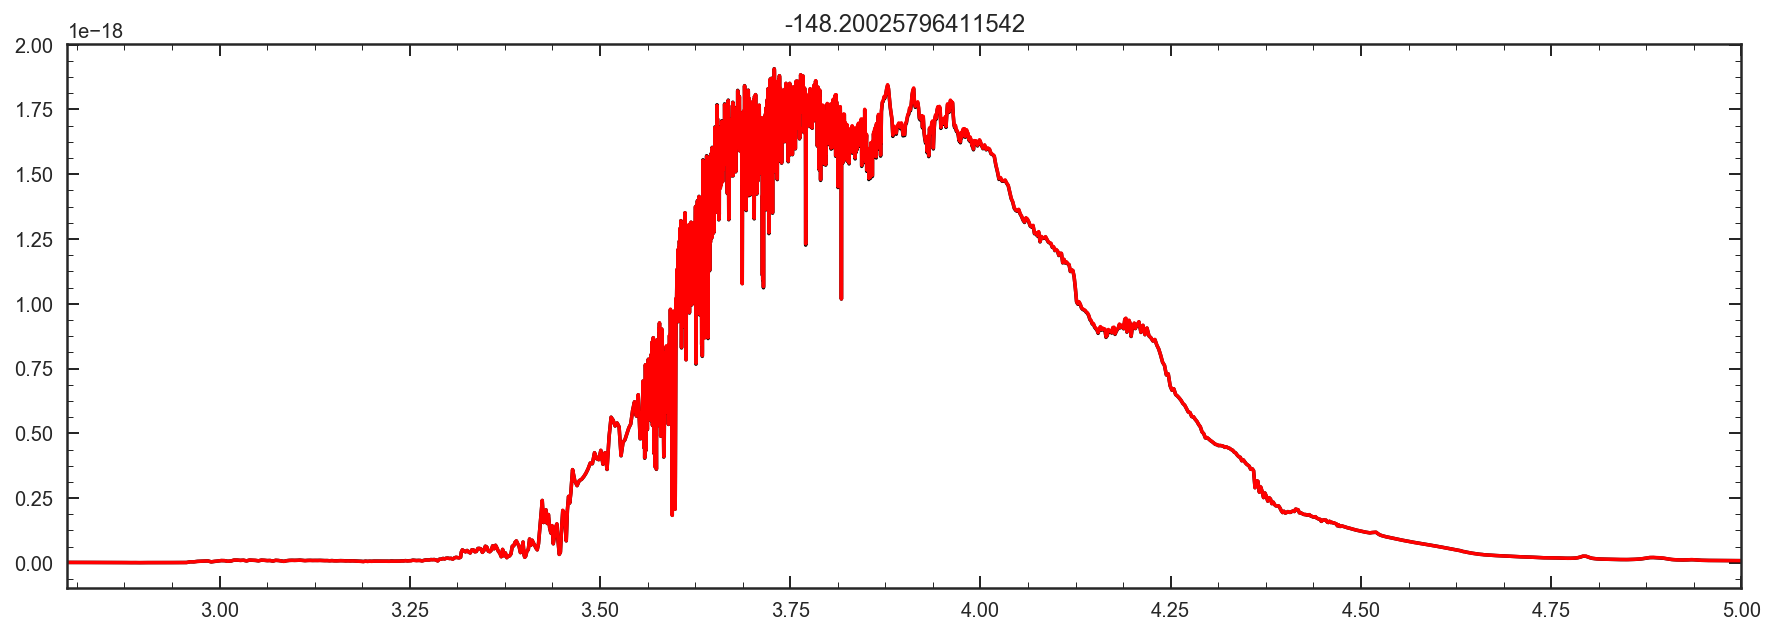

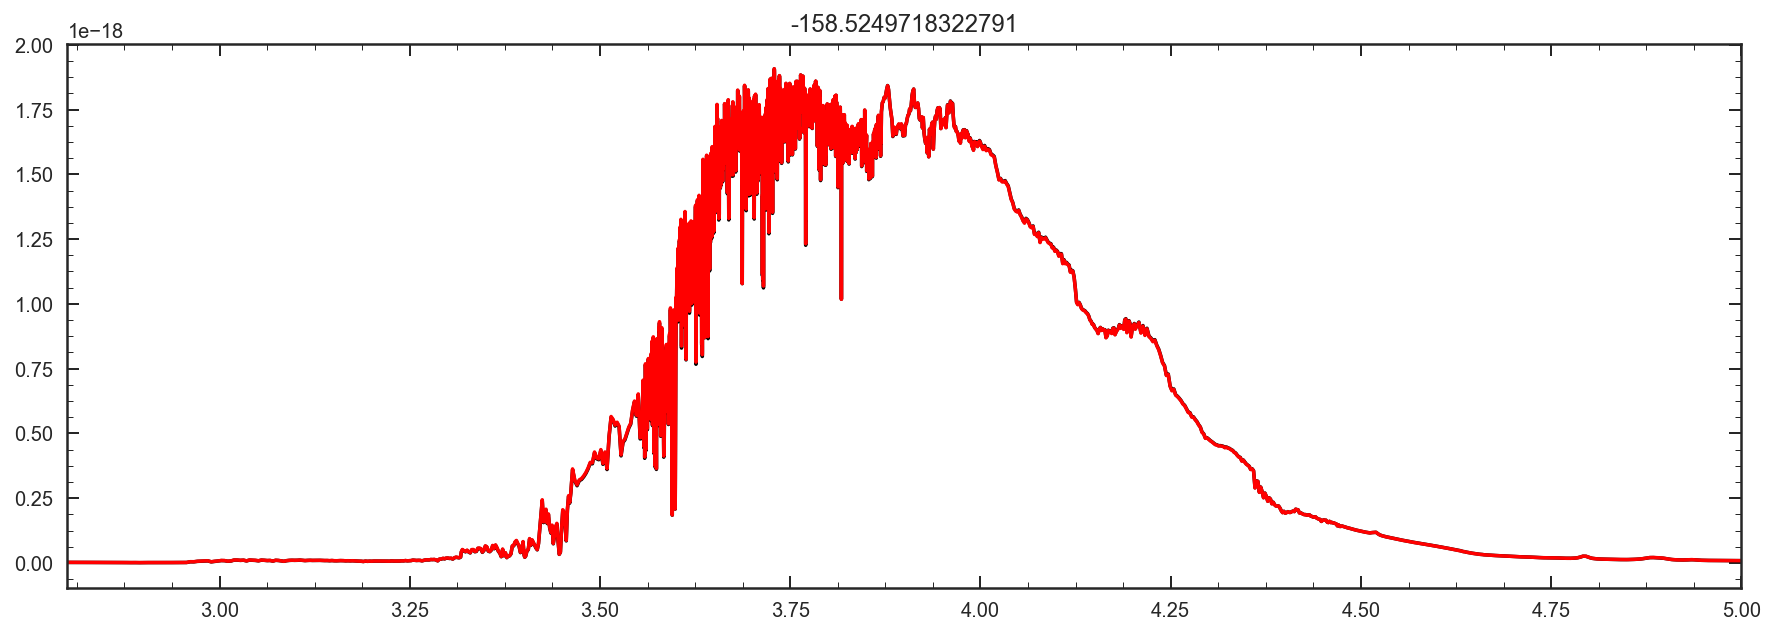

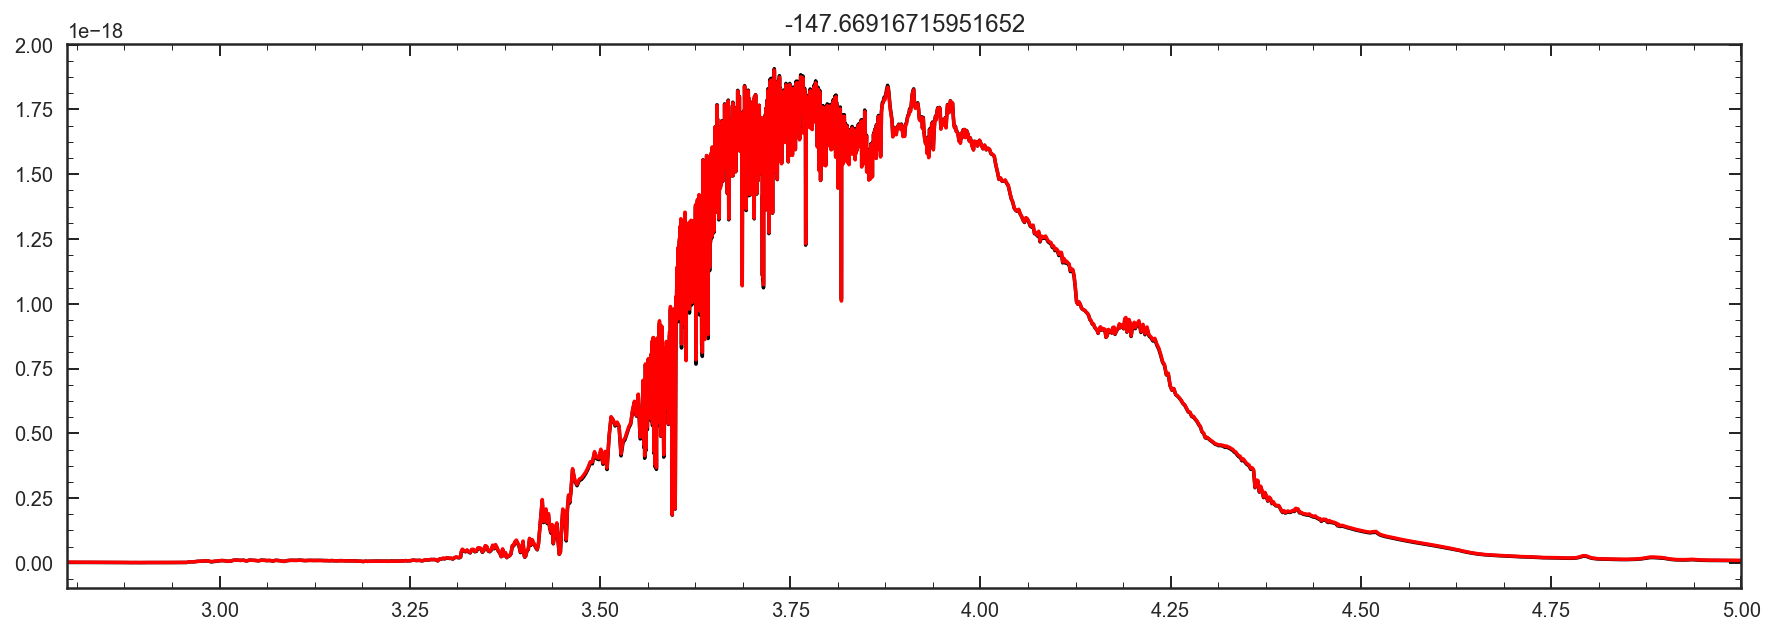

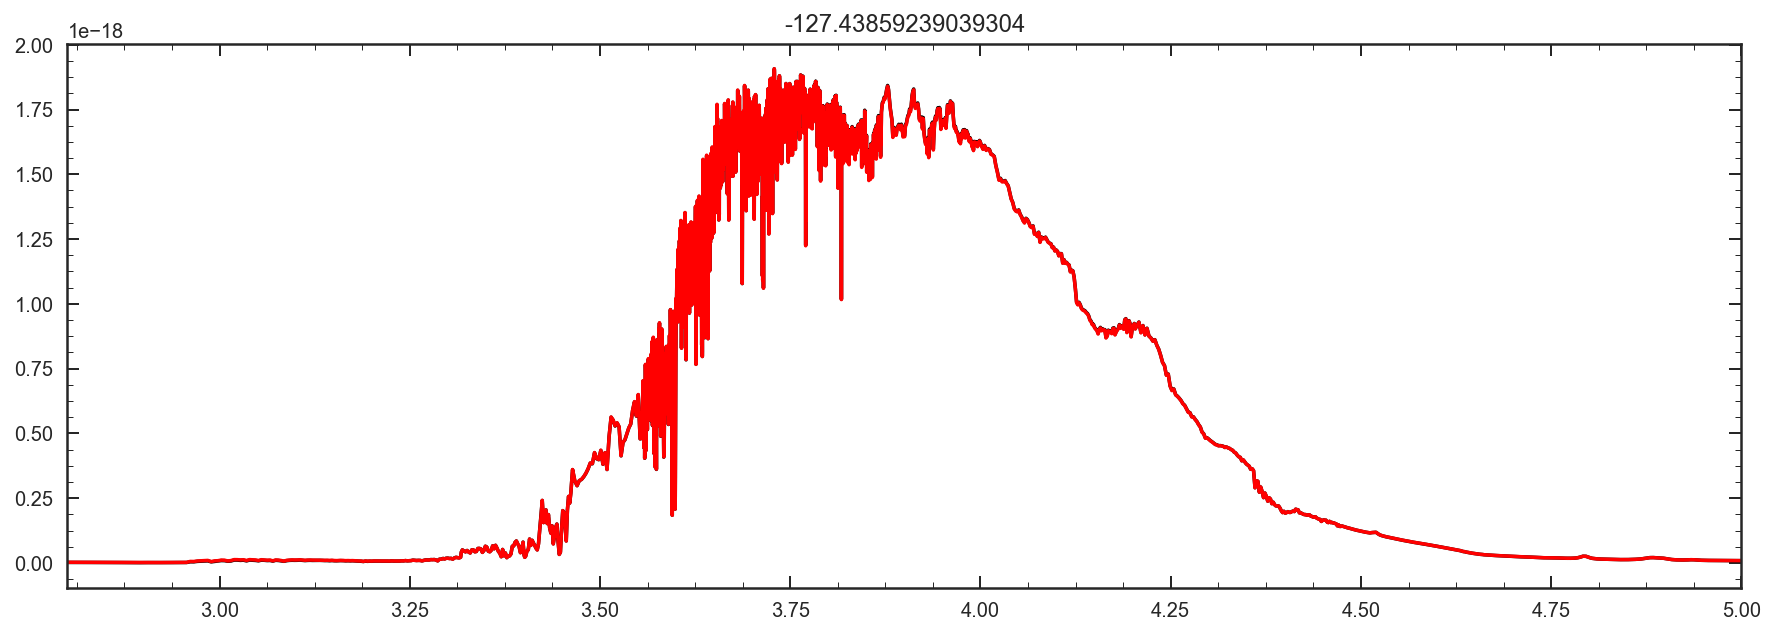

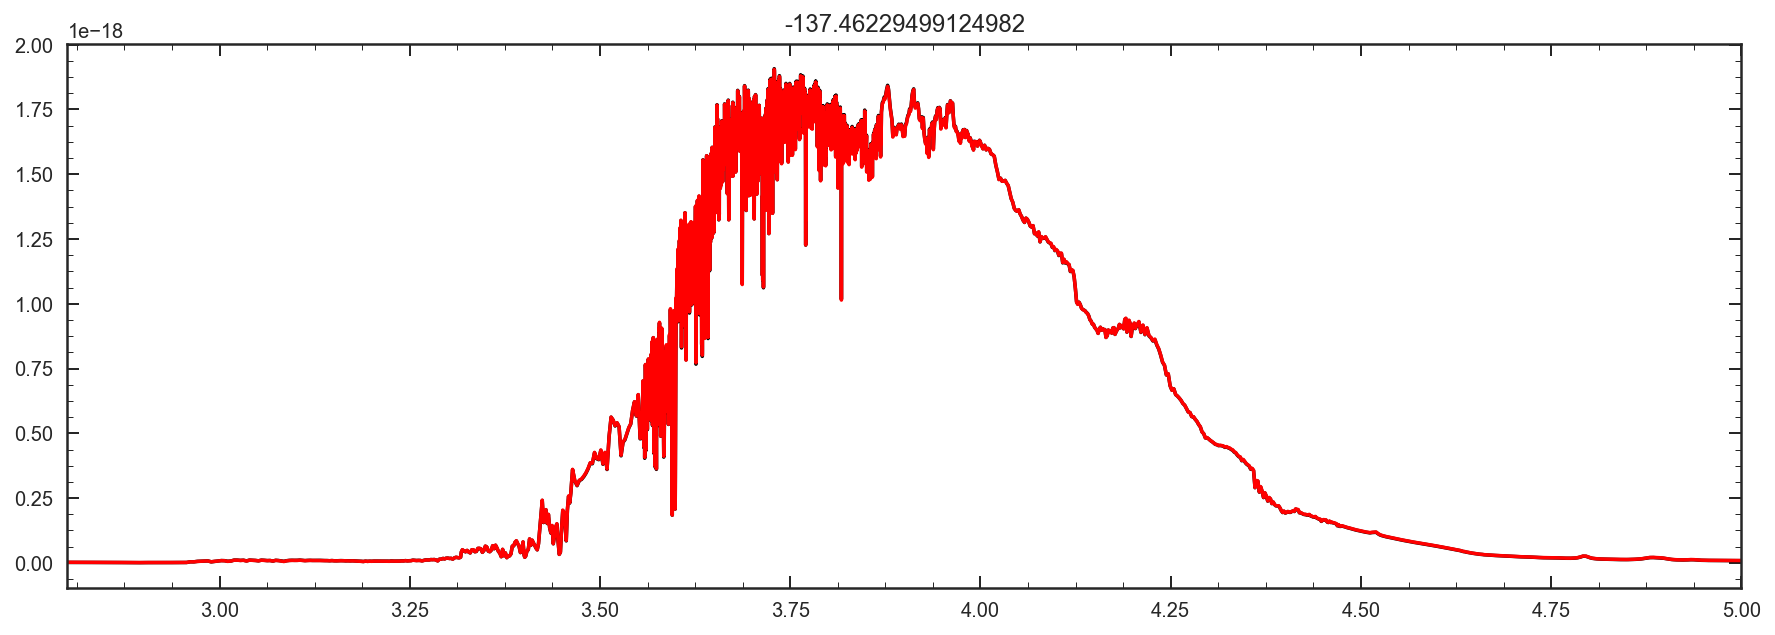

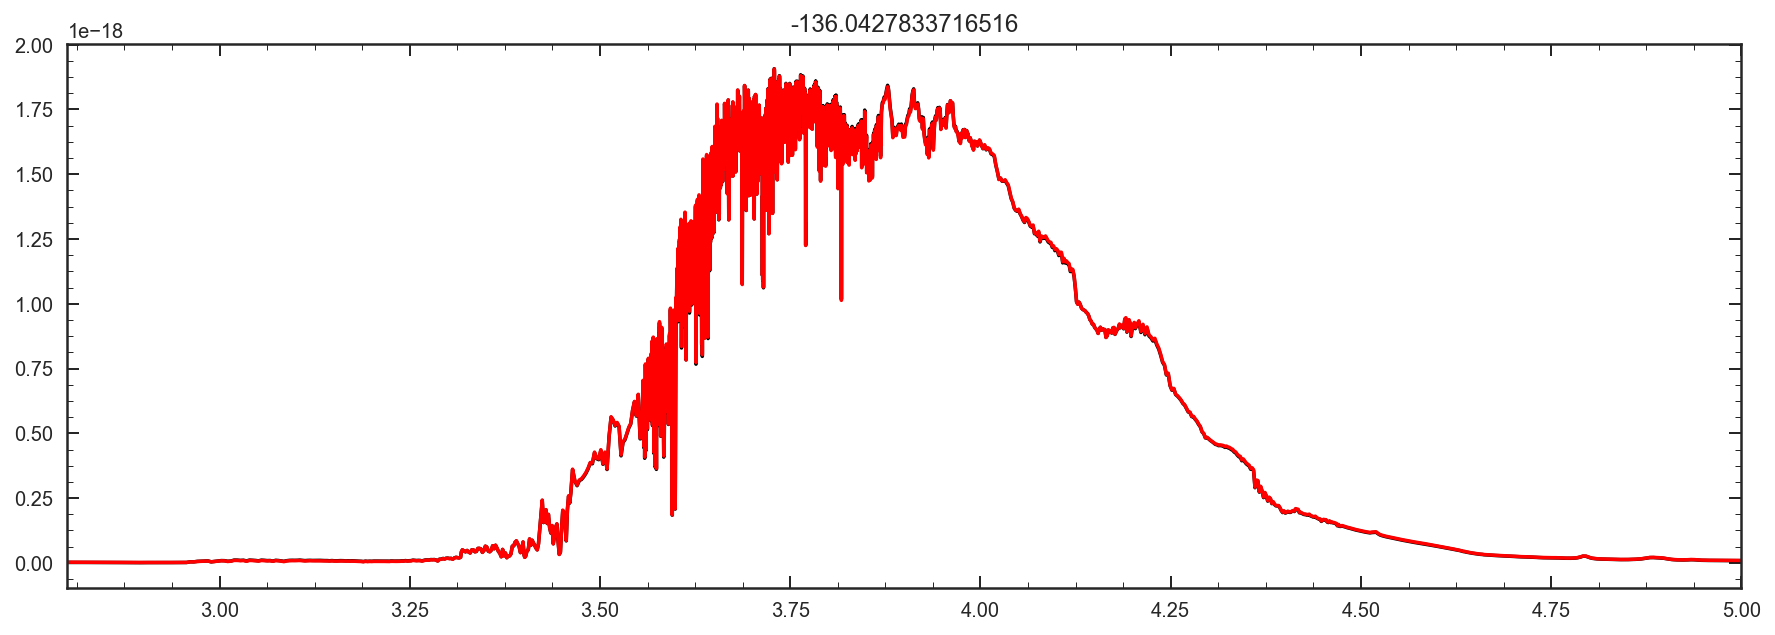

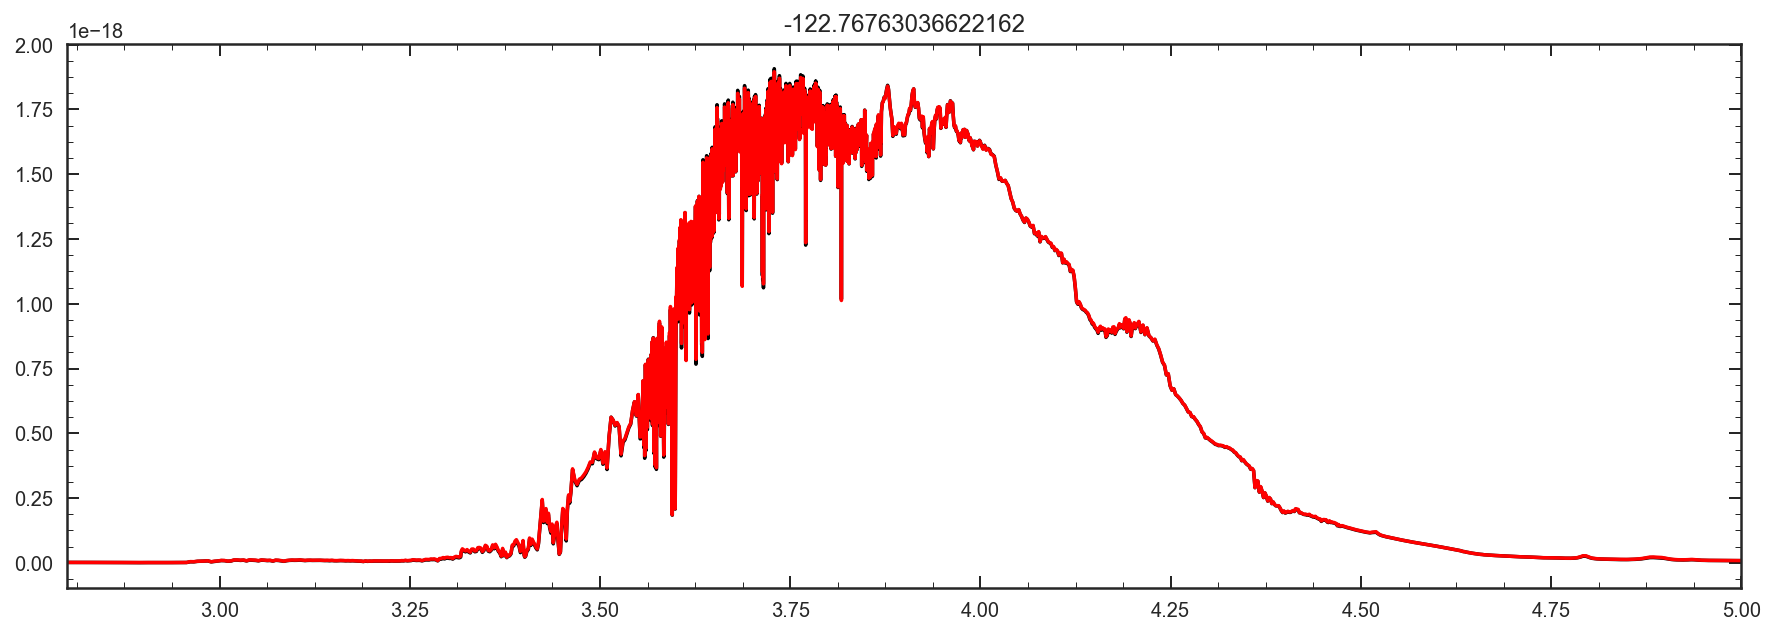

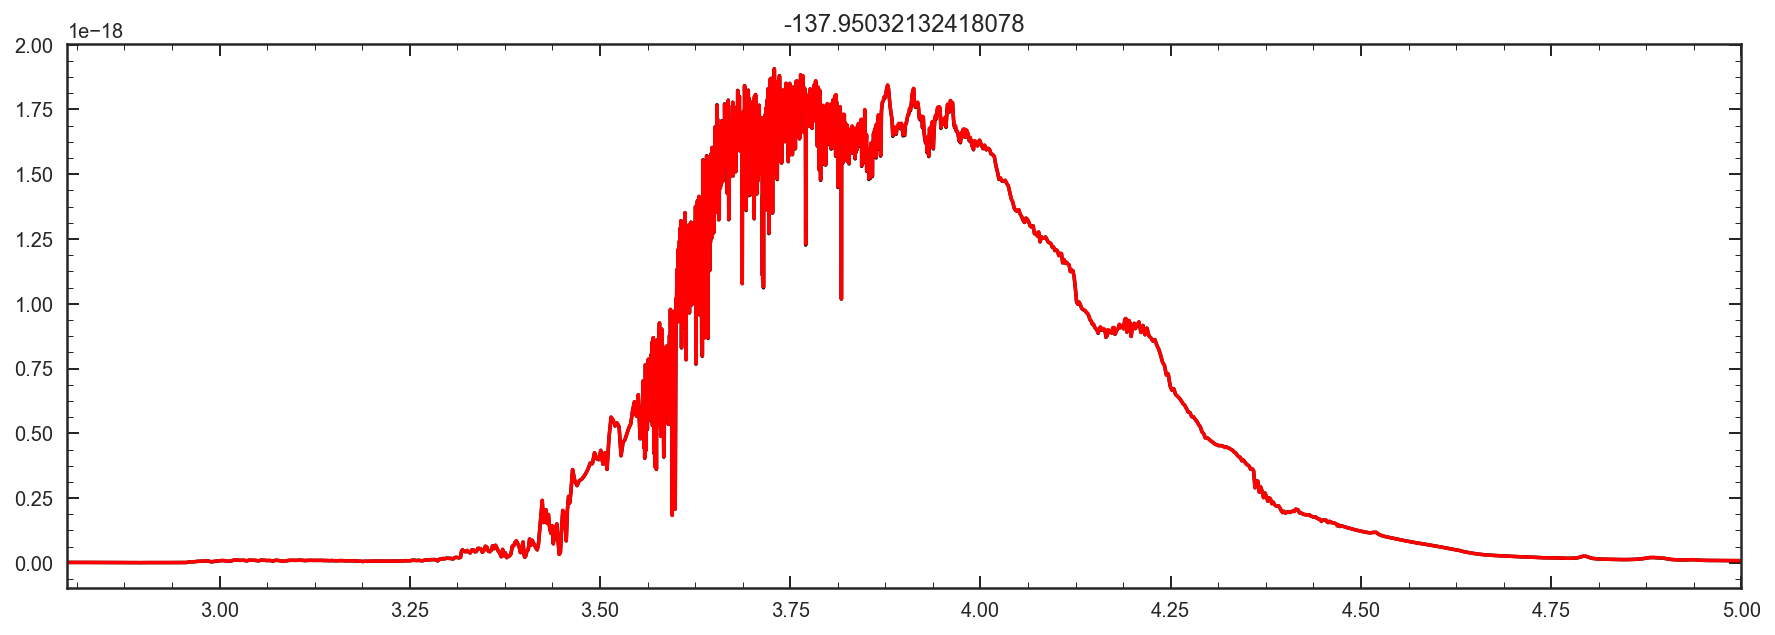

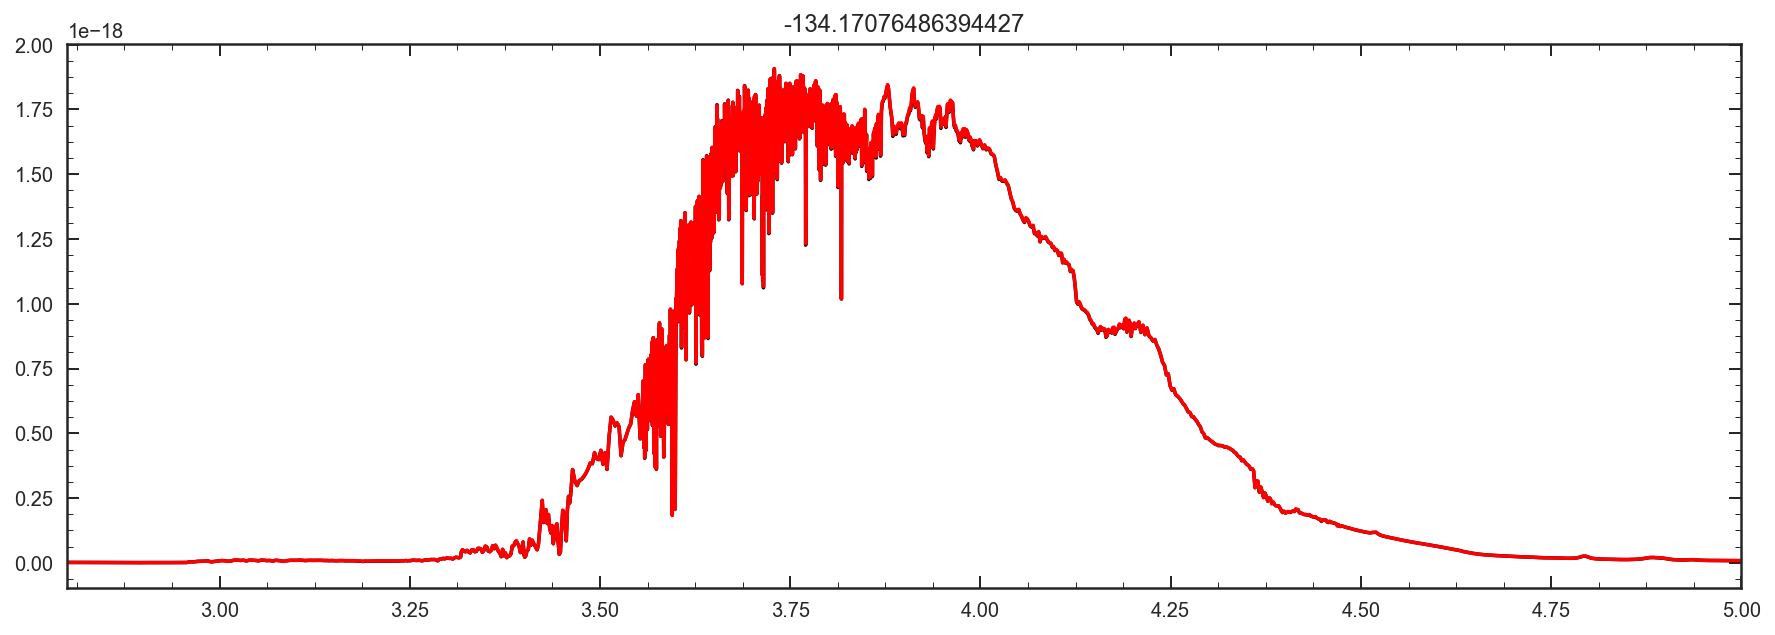

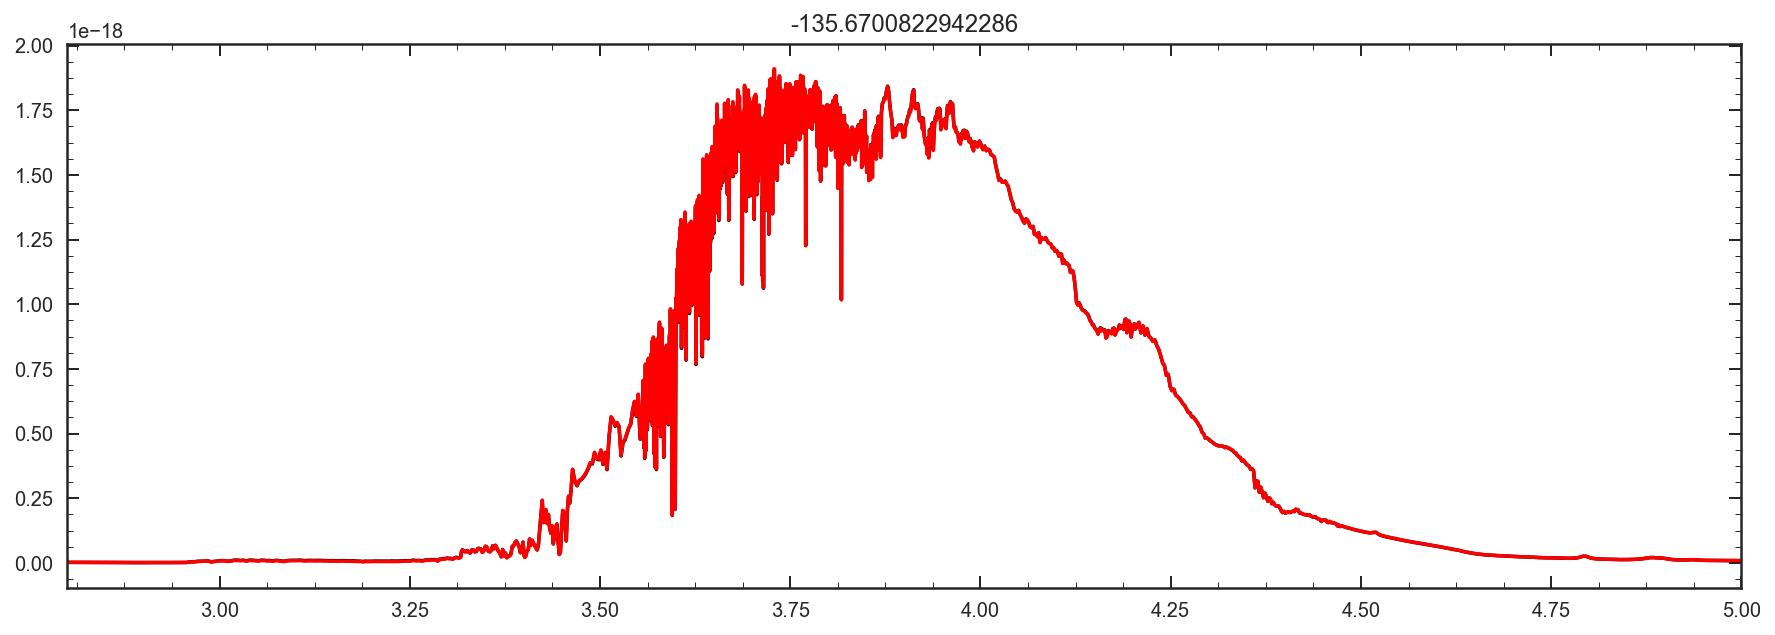

In [75]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 3, dust_type = 1)

for i in range(10):
    dres = np.load(multi_list[i]).item()
    bfZ, bft, bft1, bft2, bft3, bft4, bft5, bft6, \
    bft7, bft8, bft9, bft10, bfz, bfd, bflm, logl = \
    np.load('../data/bestfits/sim_test_delay_to_tab_continuity_prior_multi_{0}_bfit.npy'.format(i+1))

    sp.params['dust2'] = bfd
    sp.params['dust1'] = bfd
    sp.params['logzsol'] = np.log10(bfZ)
    sp.set_tabular_sfh(LBT,np.array([bft1, bft2, bft3, bft4, bft5, bft6, bft7, bft8, bft9, bft10]))

    wave, flux = sp.get_spectrum(tage = bft, peraa = True)

    mp1 = sp.stellar_mass
 
    D_l = cosmo.luminosity_distance(bfz).value # in Mpc
    MT = (10**bflm / mp1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

    plt.figure(figsize=[15,5])
    plt.plot(np.log10(wave2), flux2 * mass_transform,'k')
    plt.plot(np.log10(wave), flux * MT,'b')
    plt.title(dres.logl[-1])
    plt.xlim(2.8,5)
    
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)

for i in range(10):
    dres = np.load(multi_list[i]).item()
    bfZ1,bfZ2,bfZ3,bfZ4,bfZ5,bfZ6,bfZ7,bfZ8,bfZ9,bfZ10, bft, bft1, bft2, bft3, bft4, bft5, bft6, \
    bft7, bft8, bft9, bft10, bfz, bfd, bflm, logl = \
    np.load('../data/bestfits/sim_test_delay_to_tab_continuity_prior_multi_metal_{0}_bfit.npy'.format(i+1))

    sp.params['dust2'] = bfd
    sp.params['dust1'] = bfd
    sp.params['logzsol'] = np.log10(bfZ)
    sp.set_tabular_sfh(LBT,np.array([bft1, bft2, bft3, bft4, bft5, bft6, bft7, bft8, bft9, bft10]),
                      Z = np.array([bfZ1,bfZ2,bfZ3,bfZ4,bfZ5,bfZ6,bfZ7,bfZ8,bfZ9,bfZ10])*0.019)

    wave, flux = sp.get_spectrum(tage = bft, peraa = True)

    mp1 = sp.stellar_mass
 
    D_l = cosmo.luminosity_distance(bfz).value # in Mpc
    MT = (10**bflm / mp1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

    plt.figure(figsize=[15,5])
    plt.plot(np.log10(wave2), flux2 * mass_transform,'k')
    plt.plot(np.log10(wave), flux * MT,'r')
    plt.title(dres.logl[-1])
    plt.xlim(2.8,5)

# Compare td SFHs

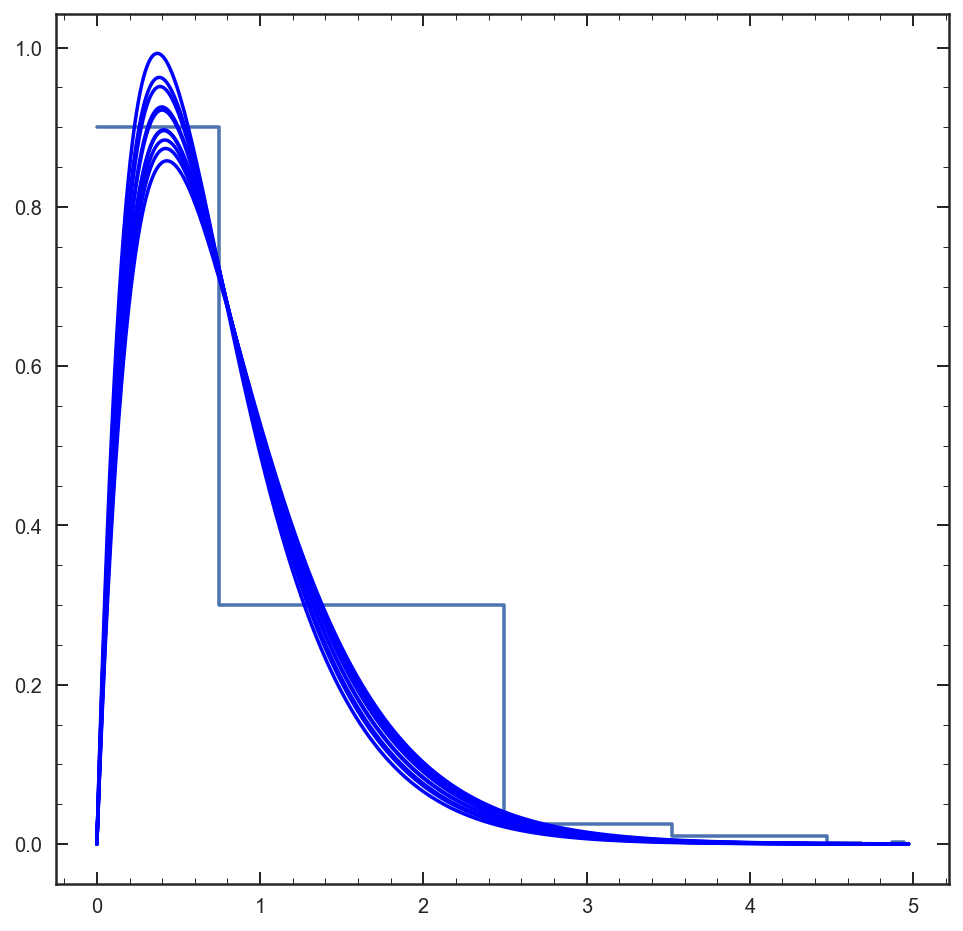

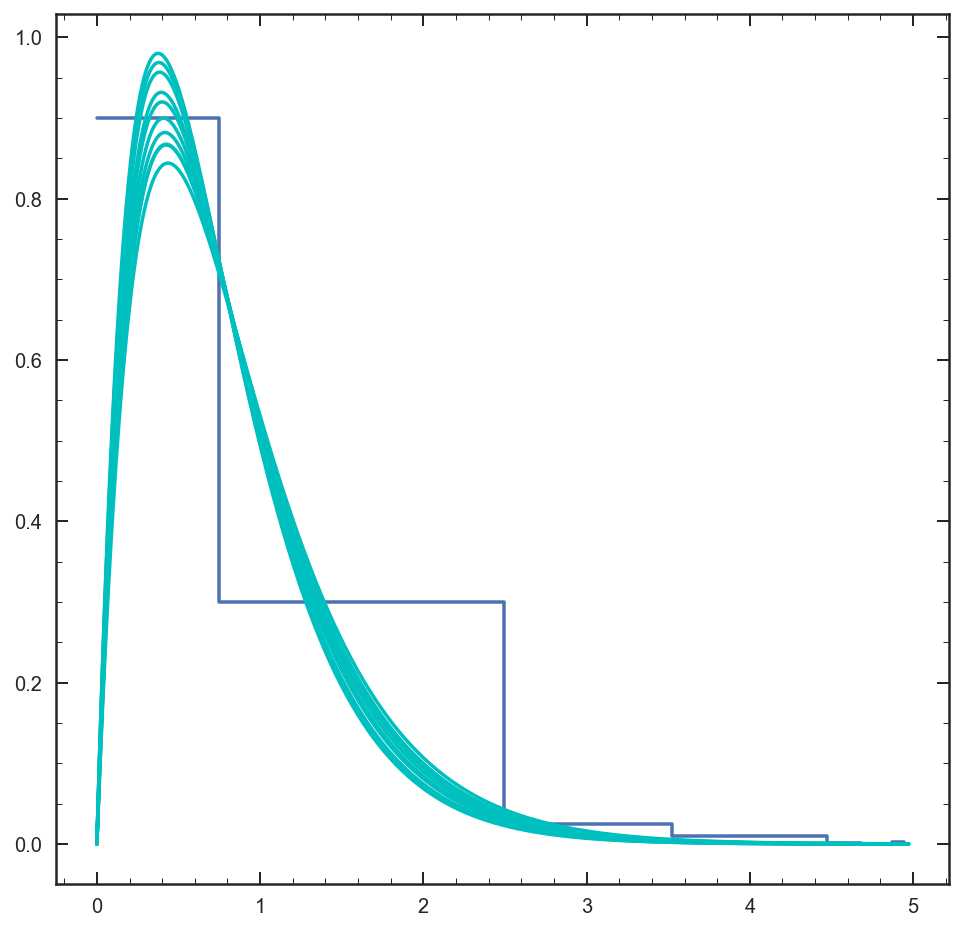

In [129]:
multi_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*multi**') if 'lwa' not in os.path.basename(fn)]
balls_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*balls**') if 'lwa' not in os.path.basename(fn)]
single_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*single**') if 'lwa' not in os.path.basename(fn)]
cubes_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*cubes**') if 'lwa' not in os.path.basename(fn)]

tab_sfh = np.array([0.9, 0.3, 0.025, 0.01, 0.01, 0.001, 0.00001, 0.0002, 0.002, 0.0001])

T= np.arange(0,Oldest_galaxy(1.25)+.001,.001)

plt.figure(figsize=[8,8])
plt.step(np.append(0,LBT), np.append(tab_sfh[0], tab_sfh))

for i in range(len(multi_list)):
    dres = np.load(multi_list[i]).item()
    t,pt = Get_posterior(dres.samples[:,2], dres.logwt,dres.logz)

    tau = t[pt == max(pt)][0]
    
    sfh = T * np.exp(-T / tau)

    sfh /= np.trapz(sfh,T)
    
    plt.plot(T,sfh,'b')

    
# plt.figure(figsize=[8,8])
# plt.step(np.append(0,LBT), np.append(tab_sfh[0], tab_sfh))
    
# for i in range(len(balls_list)):
#     dres = np.load(balls_list[i]).item()
#     t,pt = Get_posterior(dres.samples[:,2], dres.logwt,dres.logz)

#     tau = t[pt == max(pt)][0]
    
#     sfh = T * np.exp(-T / tau)

#     sfh /= np.trapz(sfh,T)
    
#     plt.plot(T,sfh,'r')
  

plt.figure(figsize=[8,8])
plt.step(np.append(0,LBT), np.append(tab_sfh[0], tab_sfh))

for i in range(len(single_list)):
    dres = np.load(single_list[i]).item()
    t,pt = Get_posterior(dres.samples[:,2], dres.logwt,dres.logz)

    tau = t[pt == max(pt)][0]
    
    sfh = T * np.exp(-T / tau)

    sfh /= np.trapz(sfh,T)
    
    plt.plot(T,sfh,'c')

    
# plt.figure(figsize=[8,8])
# plt.step(np.append(0,LBT), np.append(tab_sfh[0], tab_sfh))

# for i in range(len(cubes_list)):
#     dres = np.load(cubes_list[i]).item()
#     t,pt = Get_posterior(dres.samples[:,2], dres.logwt,dres.logz)

#     tau = t[pt == max(pt)][0]
    
#     sfh = T * np.exp(-T / tau)

#     sfh /= np.trapz(sfh,T)
    
#     plt.plot(T,sfh,'k')

# Compare dt SFHs

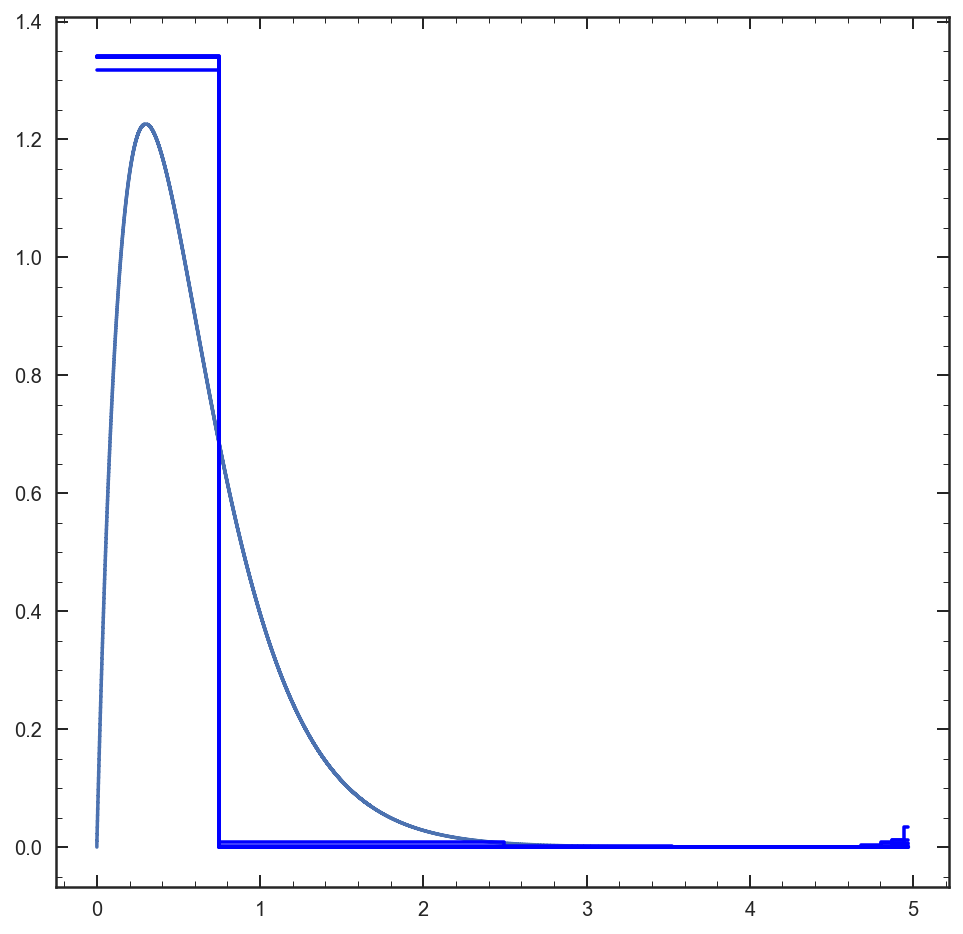

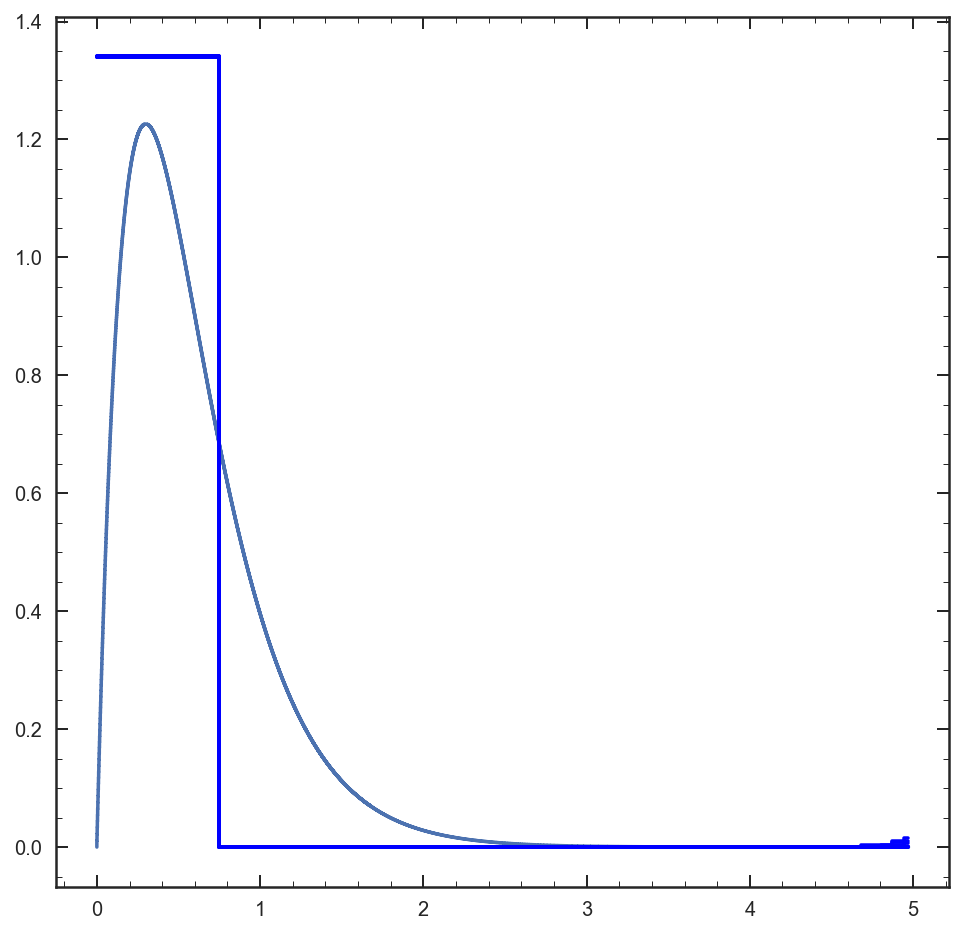

In [68]:
T= np.arange(0,Oldest_galaxy(1.25)+.001,.001)

sfh = T * np.exp(-T / 0.3)

sfh /= np.trapz(sfh,T)

plt.figure(figsize=[8,8])
plt.step(T, sfh,)

for i in range(10):
    md = np.zeros(10)

    for ii in range(10):
        t,pt = np.load('../data/posteriors/sim_test_delay_to_tab_continuity_prior_multi_{0}_Pt{1}.npy'.format(i+1,ii+1))
        md[ii] = t[pt == max(pt)]
    plt.step(np.append(0,LBT), np.append(md[0],md), 'b')

plt.figure(figsize=[8,8])
plt.step(T, sfh,)

for i in range(10):
    md = np.zeros(10)

    for ii in range(10):
        t,pt = np.load('../data/posteriors/sim_test_delay_to_tab_continuity_prior_multi_metal_{0}_Pt{1}.npy'.format(i+1,ii+1))
        md[ii] = t[pt == max(pt)]
    plt.step(np.append(0,LBT), np.append(md[0],md), 'b')

# plt.figure(figsize=[8,8])
# plt.step(T, sfh,)

# for i in range(len(balls_list)):
#     dres = np.load(balls_list[i]).item()
#     md = np.zeros(10)

#     for ii in range(10):
#         t,pt = Get_posterior(dres.samples[:,ii + 2],dres.logwt,dres.logz)
# #         md[ii], le, he = Highest_density_region(pt,t)
#         md[ii] = t[pt == max(pt)]
#     plt.step(np.append(0,LBT), np.append(md[0],md), 'r')
    
# plt.figure(figsize=[8,8])
# plt.step(T, sfh,)

# for i in range(len(single_list)):
#     dres = np.load(single_list[i]).item()
#     md = np.zeros(10)

#     for ii in range(10):
#         t,pt = Get_posterior(dres.samples[:,ii + 2],dres.logwt,dres.logz)
# #         md[ii], le, he = Highest_density_region(pt,t)
#         md[ii] = t[pt == max(pt)]
#     plt.step(np.append(0,LBT), np.append(md[0],md), 'c')
    
# plt.figure(figsize=[8,8])
# plt.step(T, sfh,)

# for i in range(len(cubes_list)):
#     dres = np.load(cubes_list[i]).item()
#     md = np.zeros(10)

#     for ii in range(10):
#         t,pt = Get_posterior(dres.samples[:,ii + 2],dres.logwt,dres.logz)
# #         md[ii], le, he = Highest_density_region(pt,t)
#         md[ii] = t[pt == max(pt)]
#     plt.step(np.append(0,LBT), np.append(md[0],md), 'k')

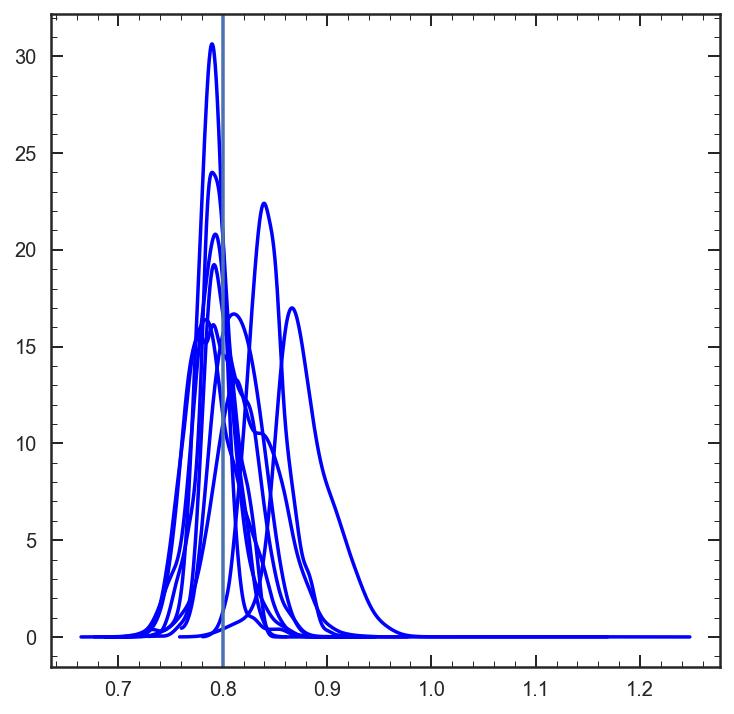

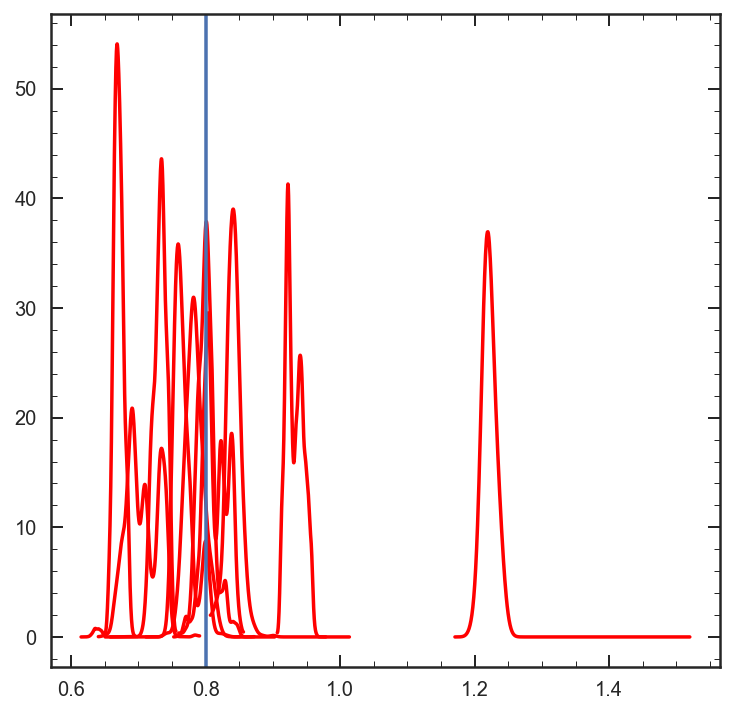

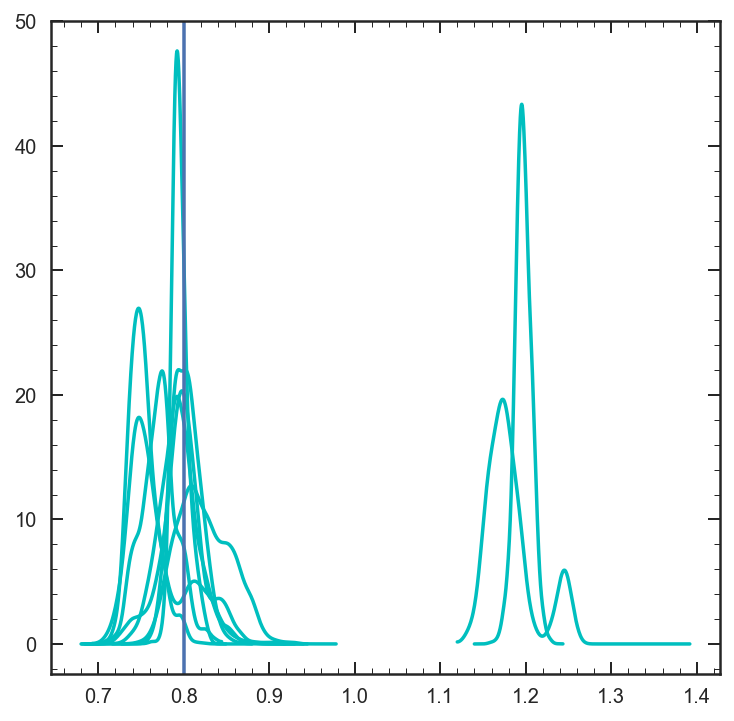

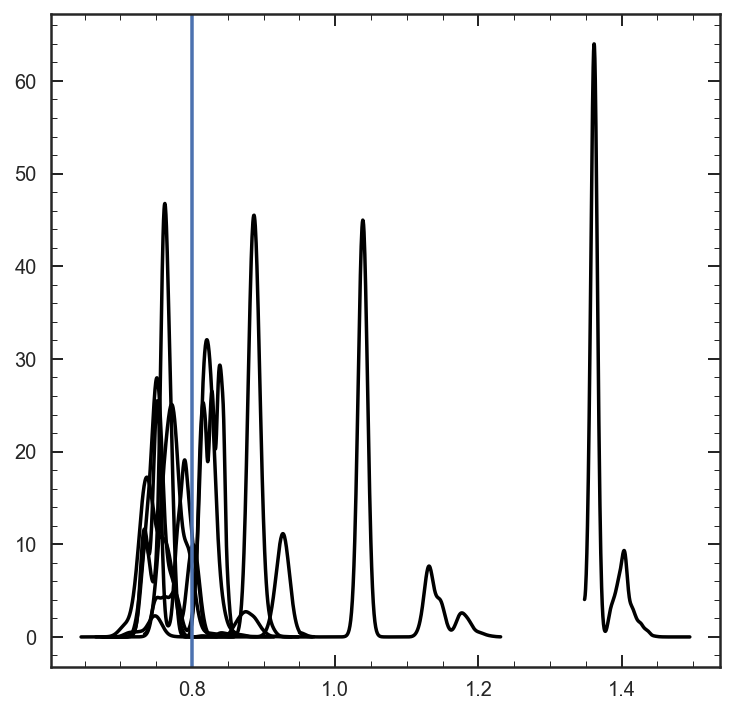

In [143]:
plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_multi_{0}.npy'.format(i+1)).item()
    m,Pm = Get_posterior(dres.samples[:,0], dres.logwt, dres.logz)
    
    plt.plot(m,Pm,'b')
plt.axvline(0.8)
    
plt.figure(figsize=[6,6])    
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_balls_{0}.npy'.format(i+1)).item()
    b,Pb = Get_posterior(dres.samples[:,0], dres.logwt, dres.logz)
    
    plt.plot(b,Pb,'r')

plt.axvline(0.8)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_single_{0}.npy'.format(i+1)).item()
    s,Ps = Get_posterior(dres.samples[:,0], dres.logwt, dres.logz)

    plt.plot(s,Ps,'c')
plt.axvline(0.8)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_cubes_{0}.npy'.format(i+1)).item()
    c,Pc = Get_posterior(dres.samples[:,0], dres.logwt, dres.logz)
    
    plt.plot(c,Pc,'k')
plt.axvline(0.8)

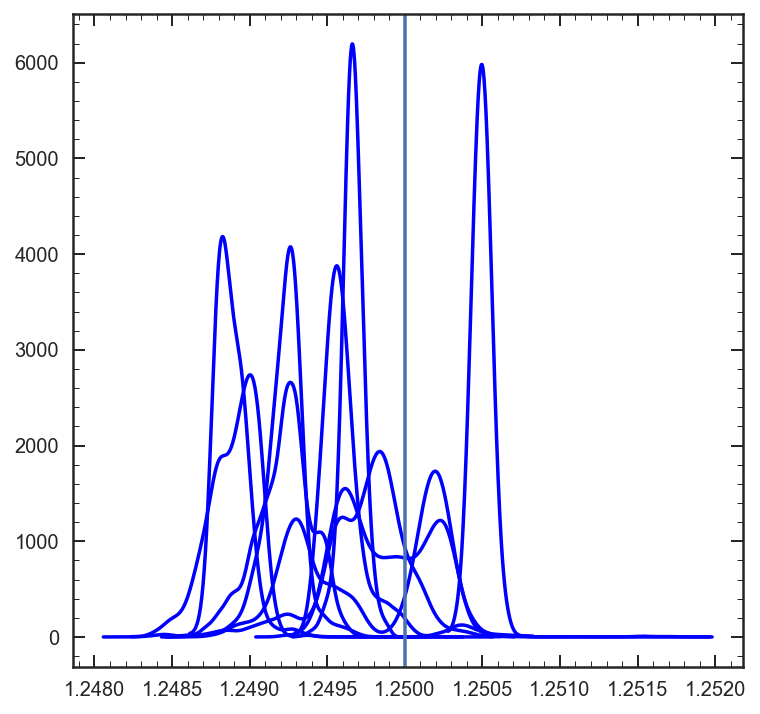

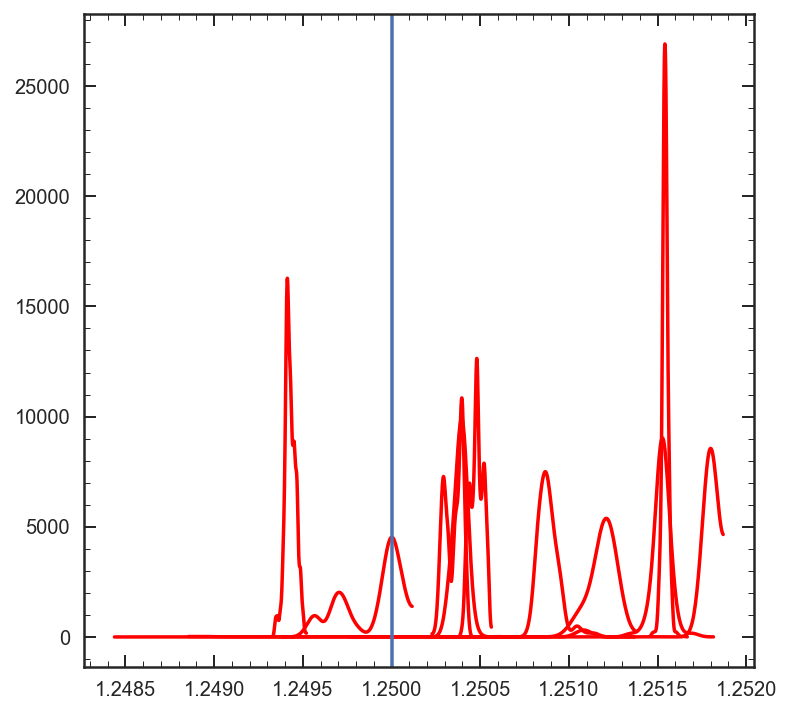

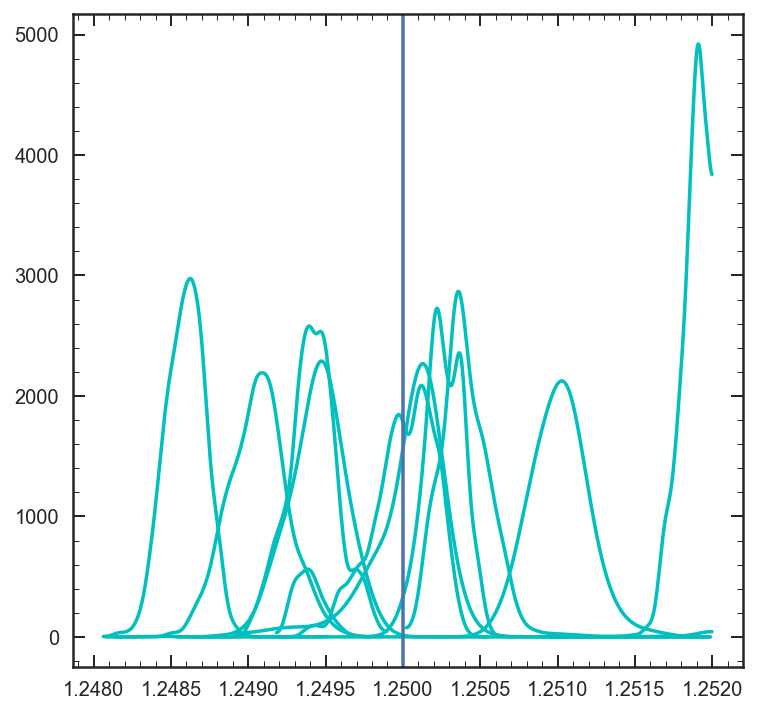

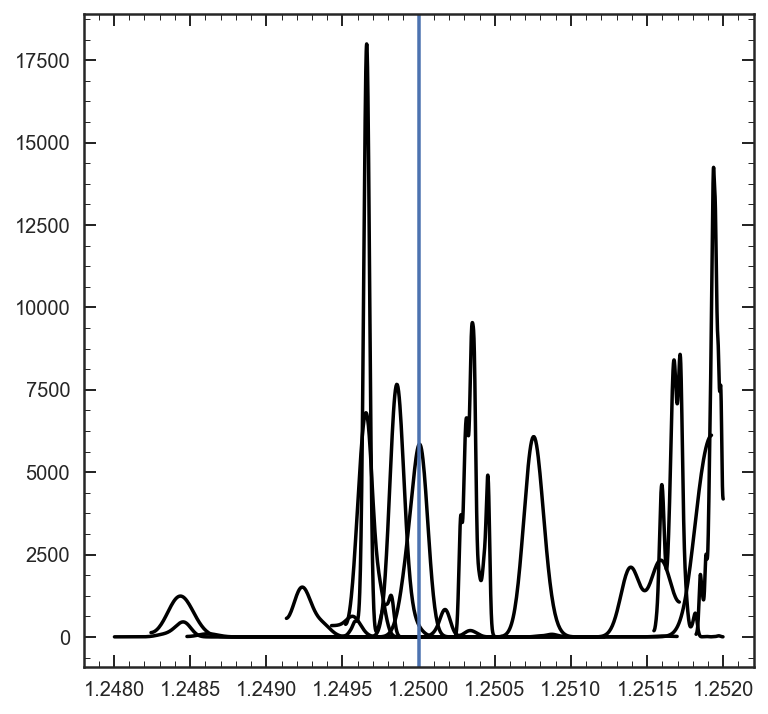

In [144]:
plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_multi_{0}.npy'.format(i+1)).item()
    m,Pm = Get_posterior(dres.samples[:,12], dres.logwt, dres.logz)
    
    plt.plot(m,Pm,'b')
plt.axvline(1.25)
    
plt.figure(figsize=[6,6])    
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_balls_{0}.npy'.format(i+1)).item()
    b,Pb = Get_posterior(dres.samples[:,12], dres.logwt, dres.logz)
    
    plt.plot(b,Pb,'r')

plt.axvline(1.25)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_single_{0}.npy'.format(i+1)).item()
    s,Ps = Get_posterior(dres.samples[:,12], dres.logwt, dres.logz)

    plt.plot(s,Ps,'c')
plt.axvline(1.25)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_cubes_{0}.npy'.format(i+1)).item()
    c,Pc = Get_posterior(dres.samples[:,12], dres.logwt, dres.logz)
    
    plt.plot(c,Pc,'k')
plt.axvline(1.25)


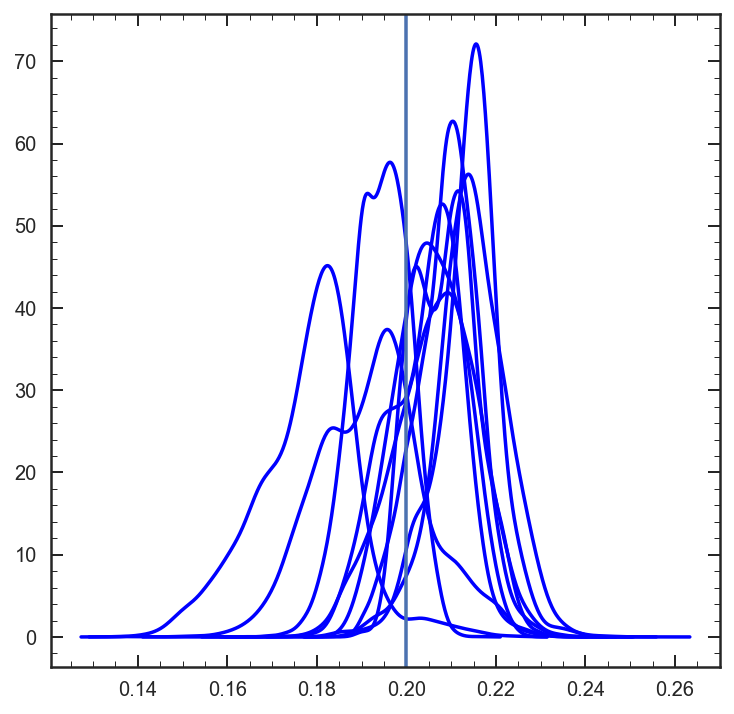

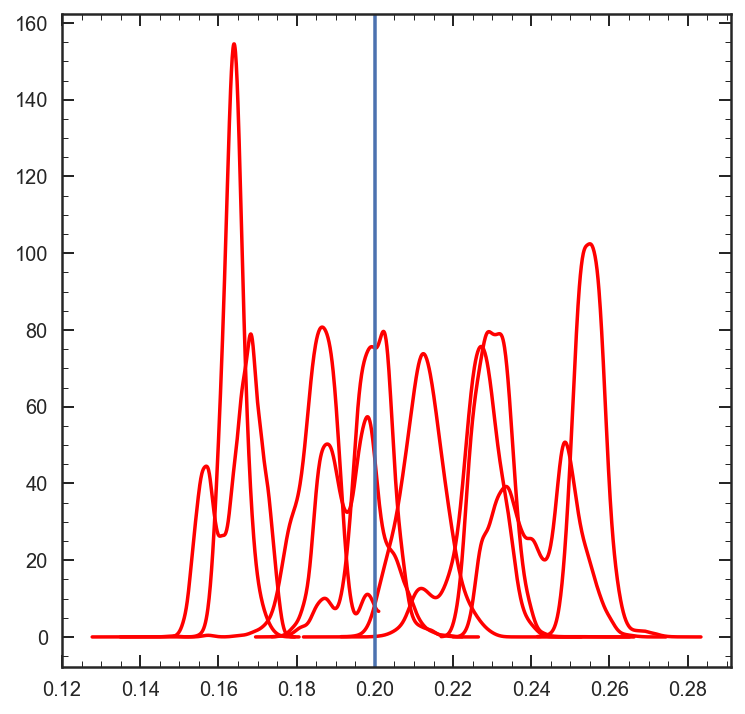

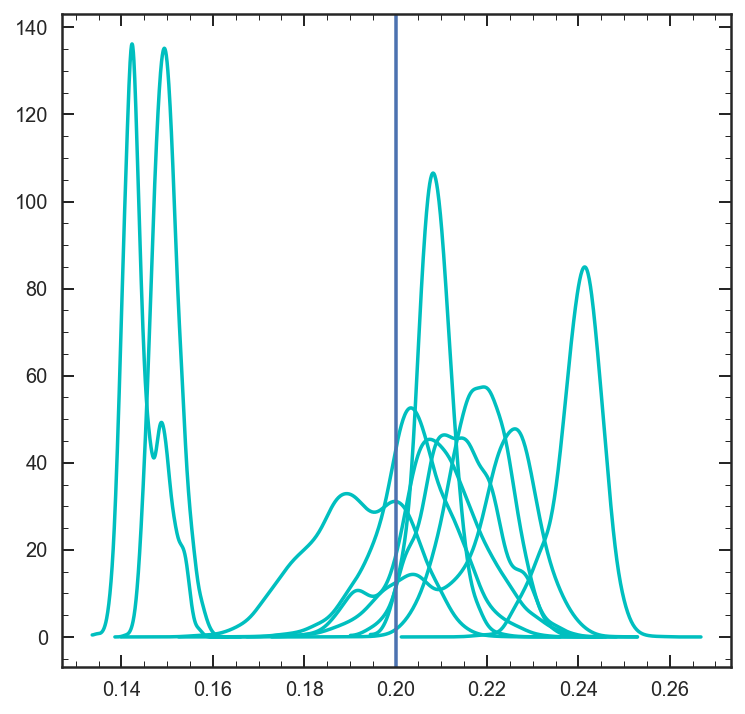

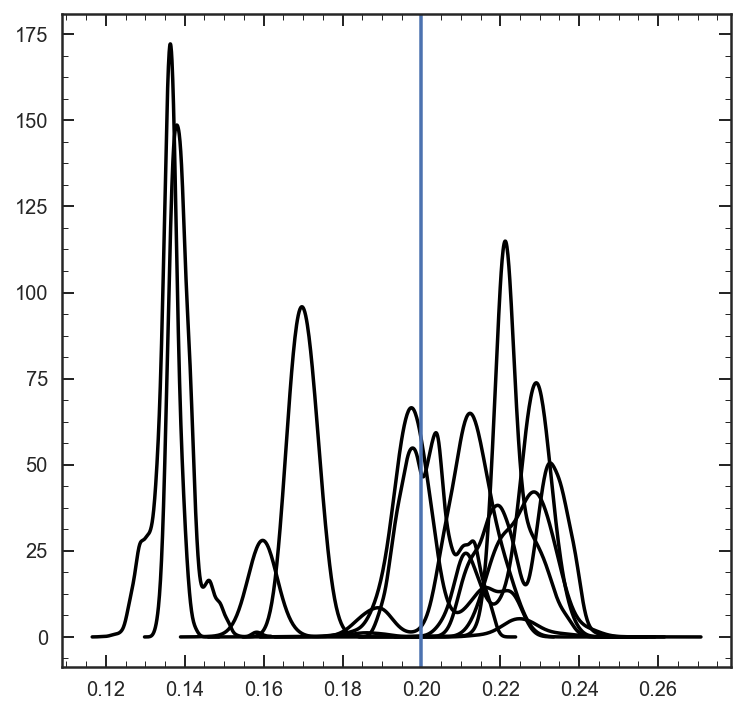

In [145]:
plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_multi_{0}.npy'.format(i+1)).item()
    m,Pm = Get_posterior(dres.samples[:,13], dres.logwt, dres.logz)
    
    plt.plot(m,Pm,'b')
plt.axvline(0.2)
    
plt.figure(figsize=[6,6])    
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_balls_{0}.npy'.format(i+1)).item()
    b,Pb = Get_posterior(dres.samples[:,13], dres.logwt, dres.logz)
    
    plt.plot(b,Pb,'r')

plt.axvline(0.2)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_single_{0}.npy'.format(i+1)).item()
    s,Ps = Get_posterior(dres.samples[:,13], dres.logwt, dres.logz)

    plt.plot(s,Ps,'c')
plt.axvline(0.2)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_cubes_{0}.npy'.format(i+1)).item()
    c,Pc = Get_posterior(dres.samples[:,13], dres.logwt, dres.logz)
    
    plt.plot(c,Pc,'k')
plt.axvline(0.2)


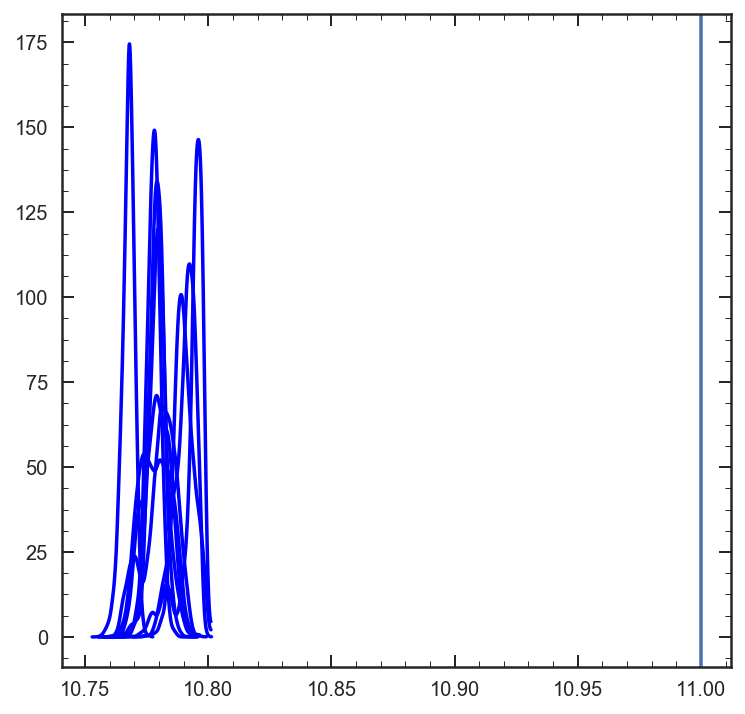

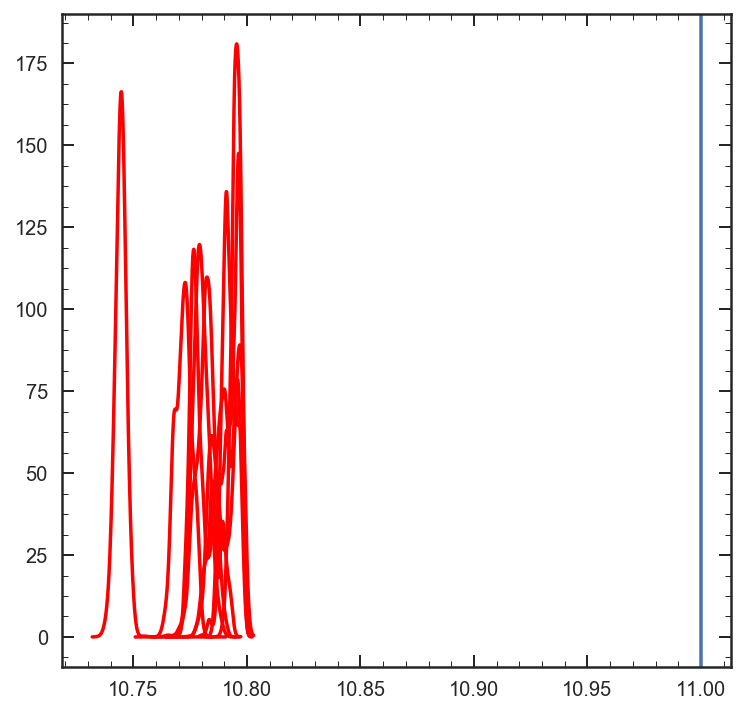

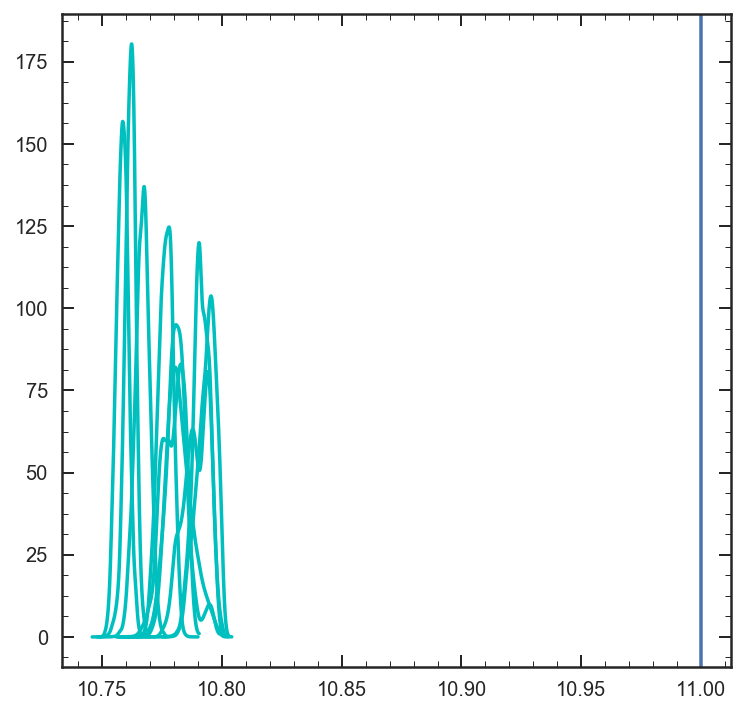

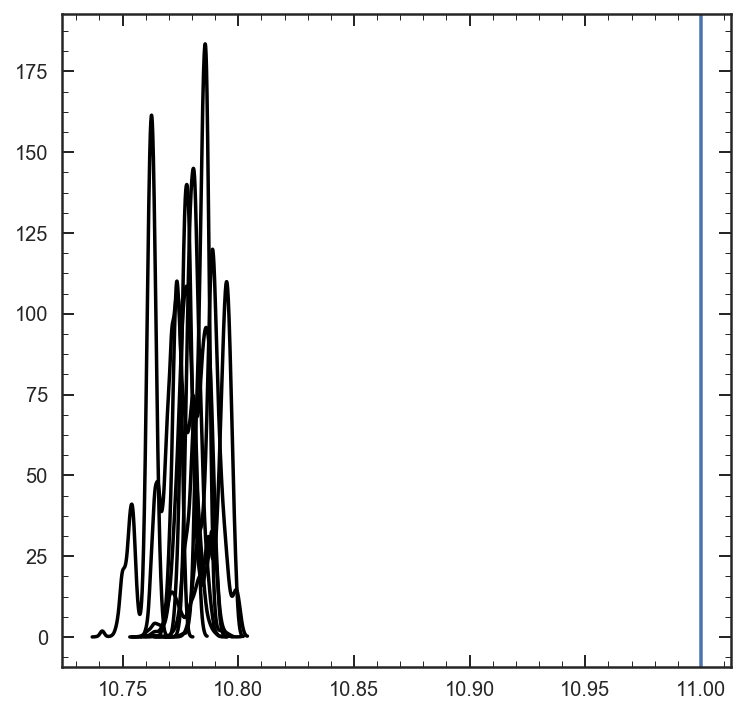

In [146]:
plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_multi_{0}.npy'.format(i+1)).item()
    m,Pm = Get_posterior(dres.samples[:,14], dres.logwt, dres.logz)
    
    plt.plot(m,Pm,'b')
plt.axvline(11)
    
plt.figure(figsize=[6,6])    
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_balls_{0}.npy'.format(i+1)).item()
    b,Pb = Get_posterior(dres.samples[:,14], dres.logwt, dres.logz)
    
    plt.plot(b,Pb,'r')

plt.axvline(11)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_single_{0}.npy'.format(i+1)).item()
    s,Ps = Get_posterior(dres.samples[:,14], dres.logwt, dres.logz)

    plt.plot(s,Ps,'c')
plt.axvline(11)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_cubes_{0}.npy'.format(i+1)).item()
    c,Pc = Get_posterior(dres.samples[:,14], dres.logwt, dres.logz)
    
    plt.plot(c,Pc,'k')
plt.axvline(11)

<Figure size 576x576 with 0 Axes>

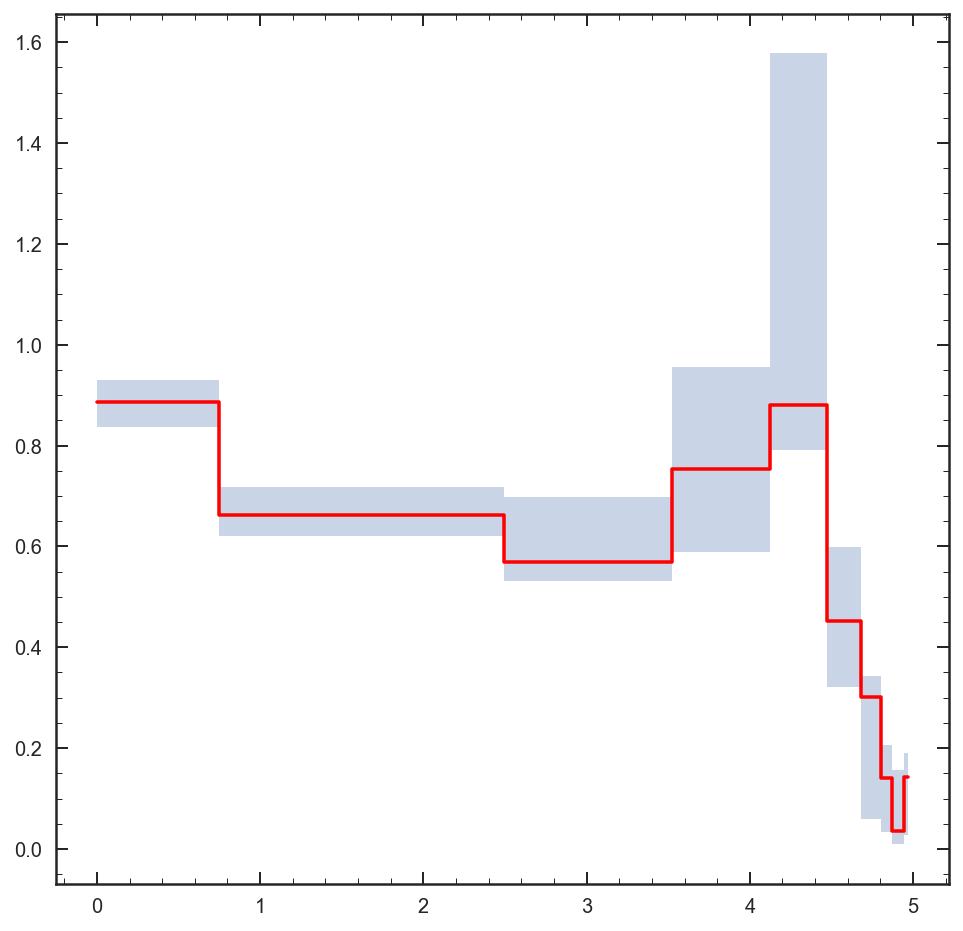

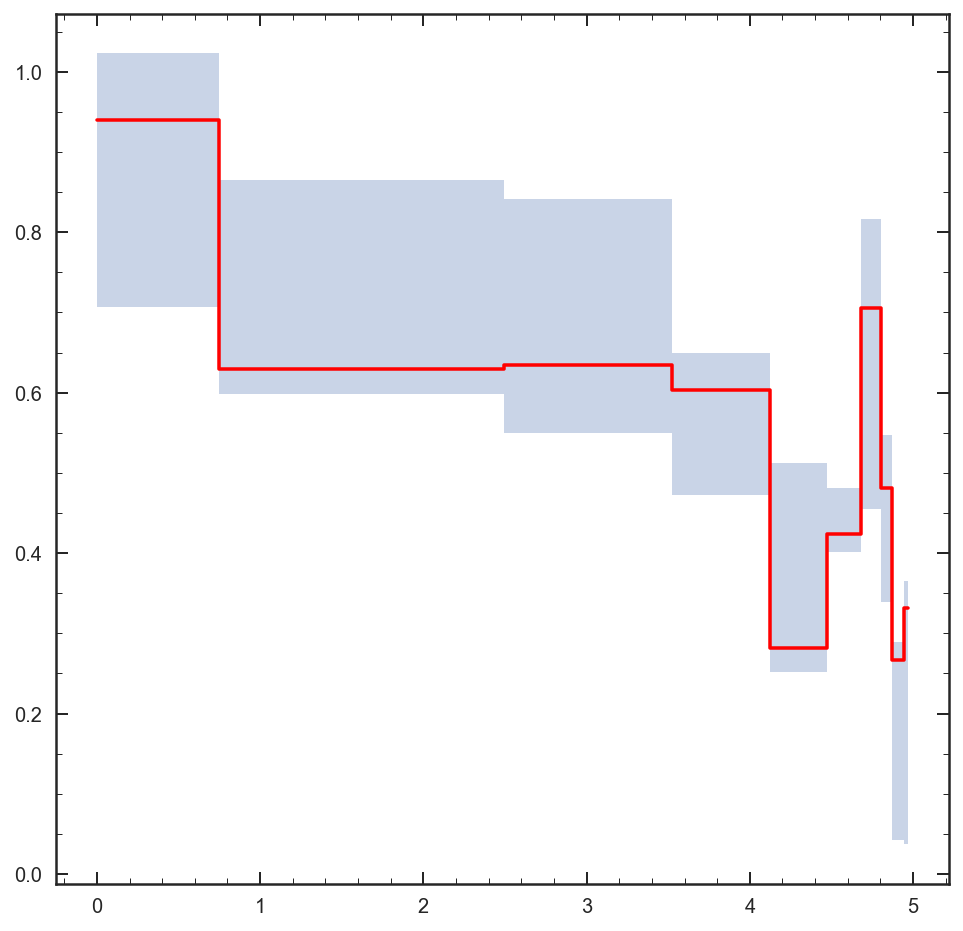

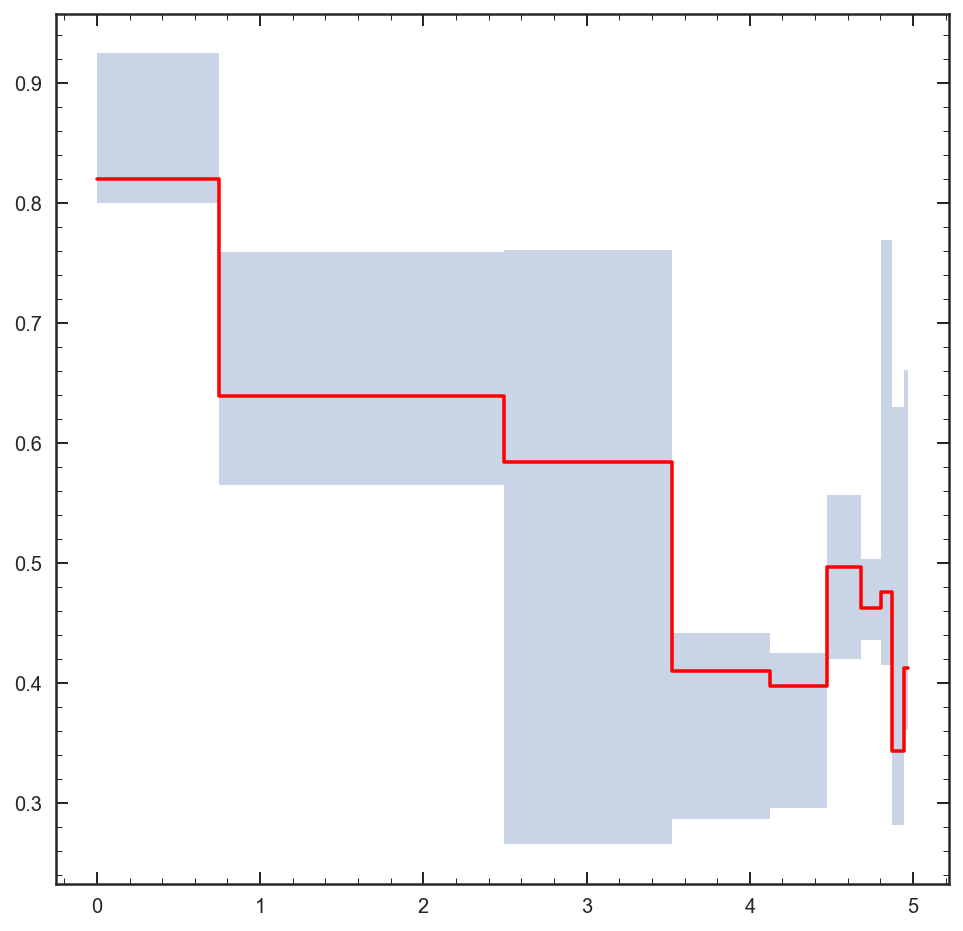

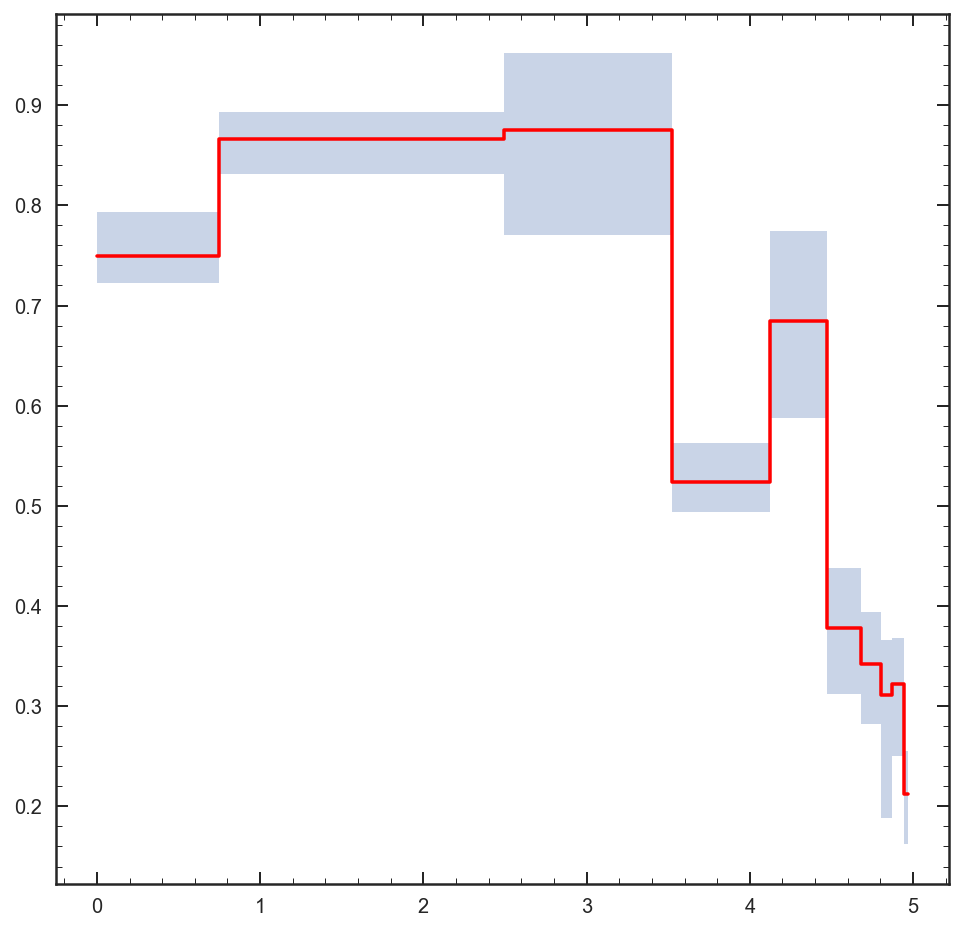

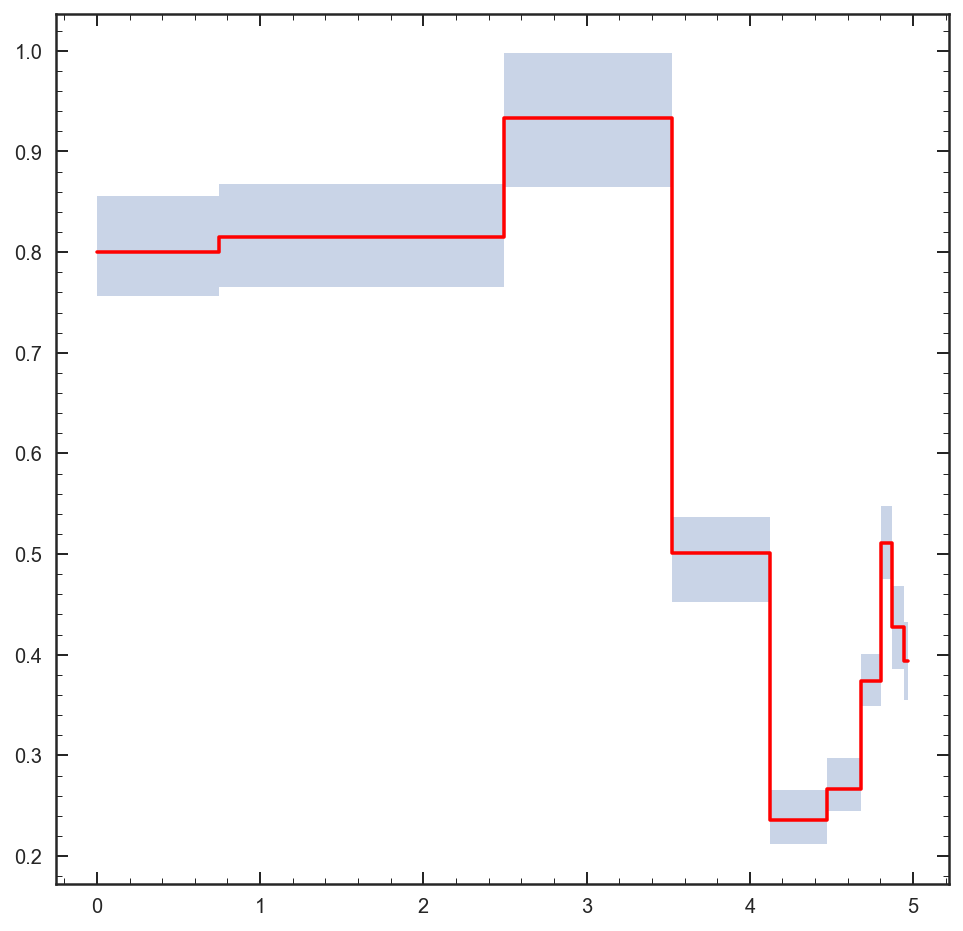

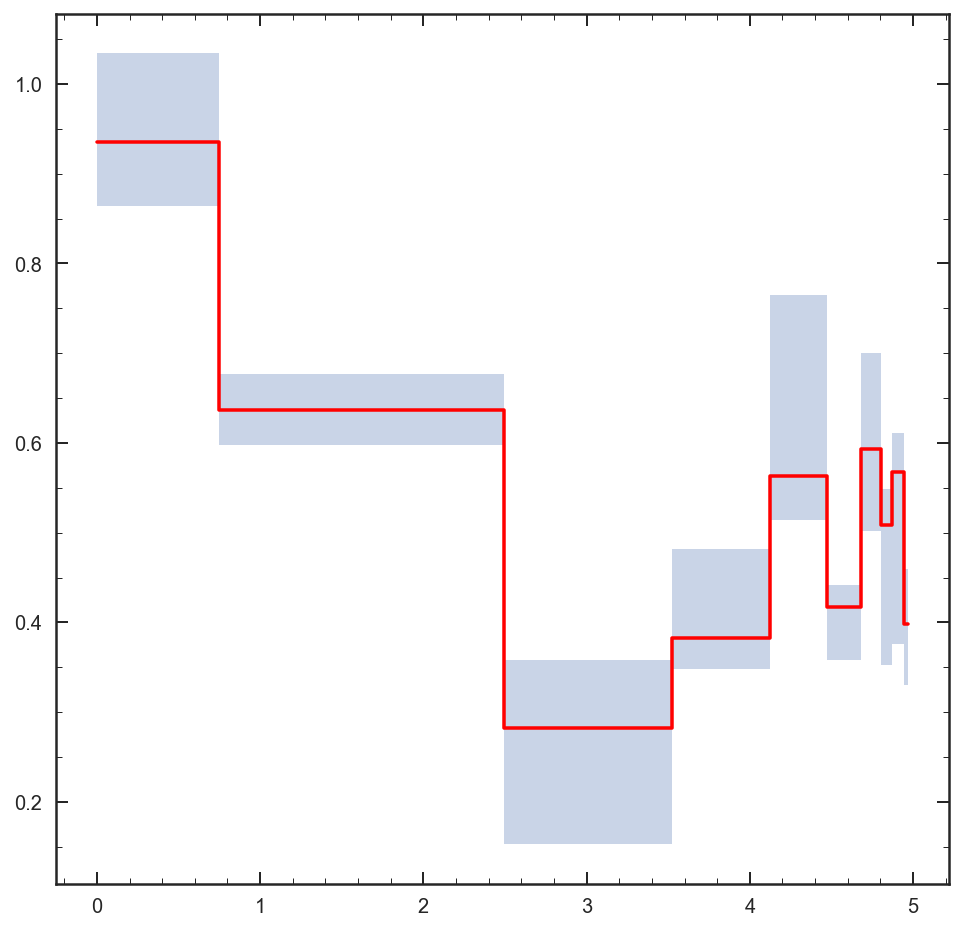

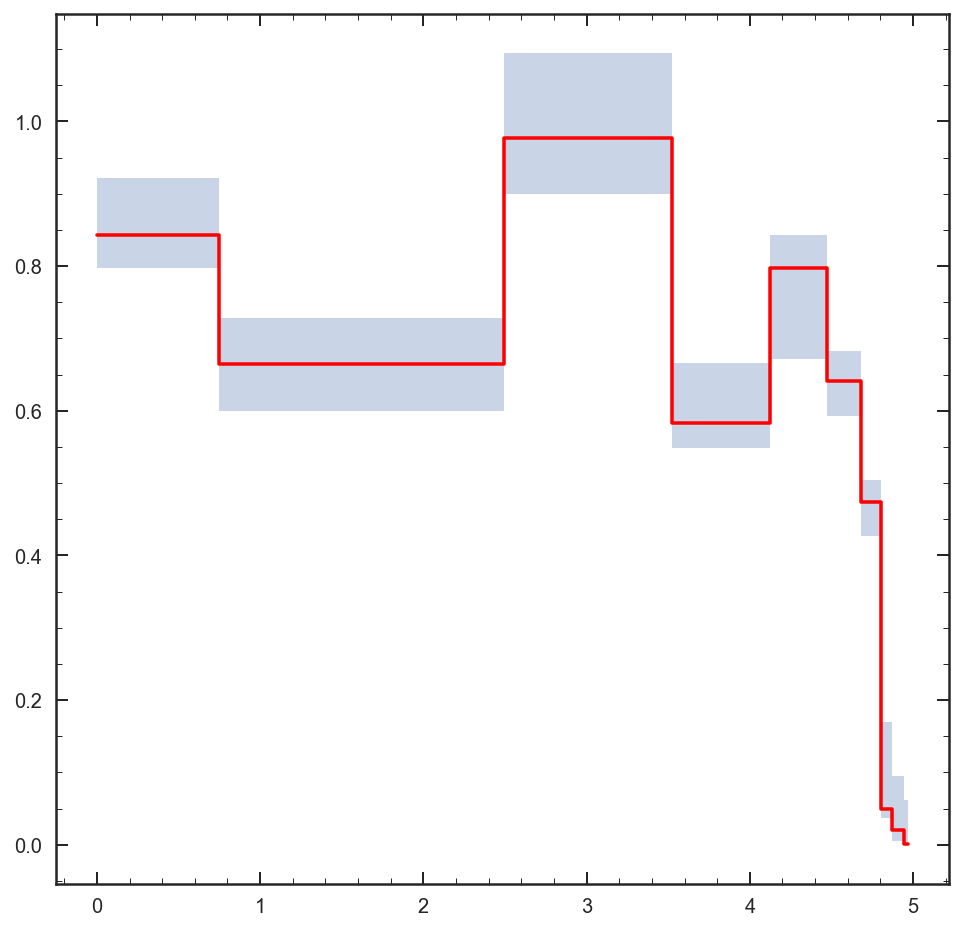

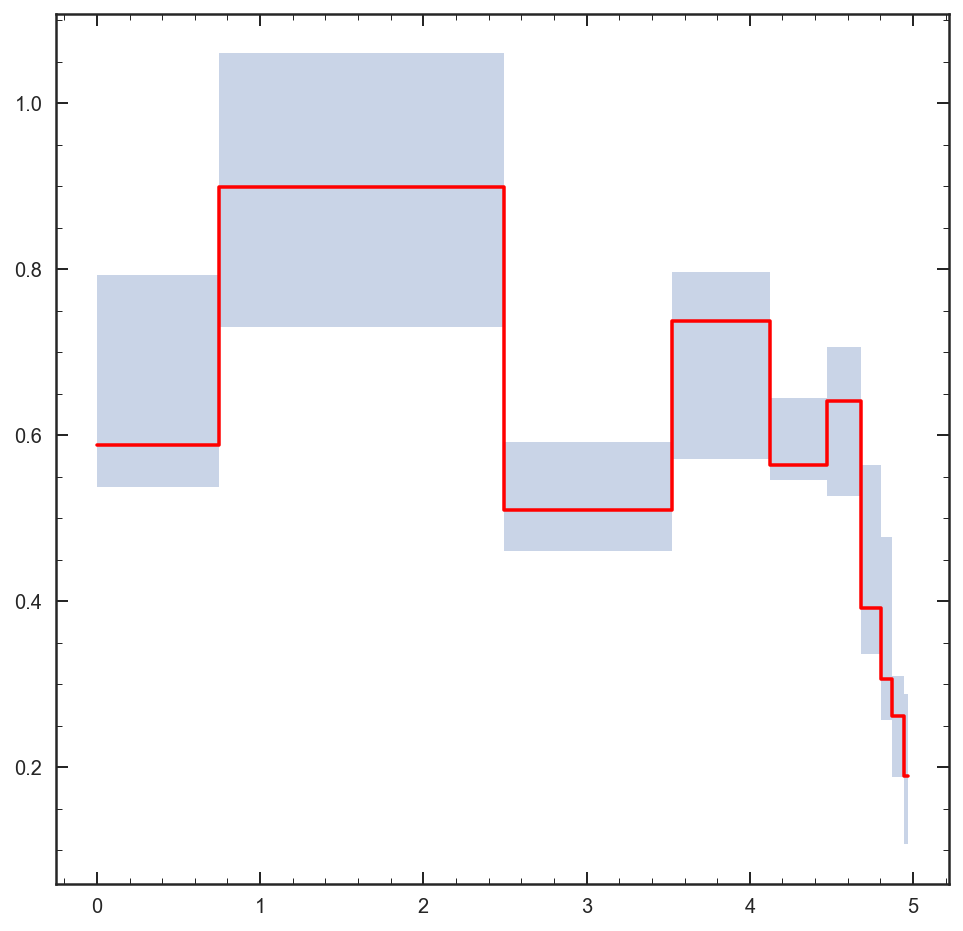

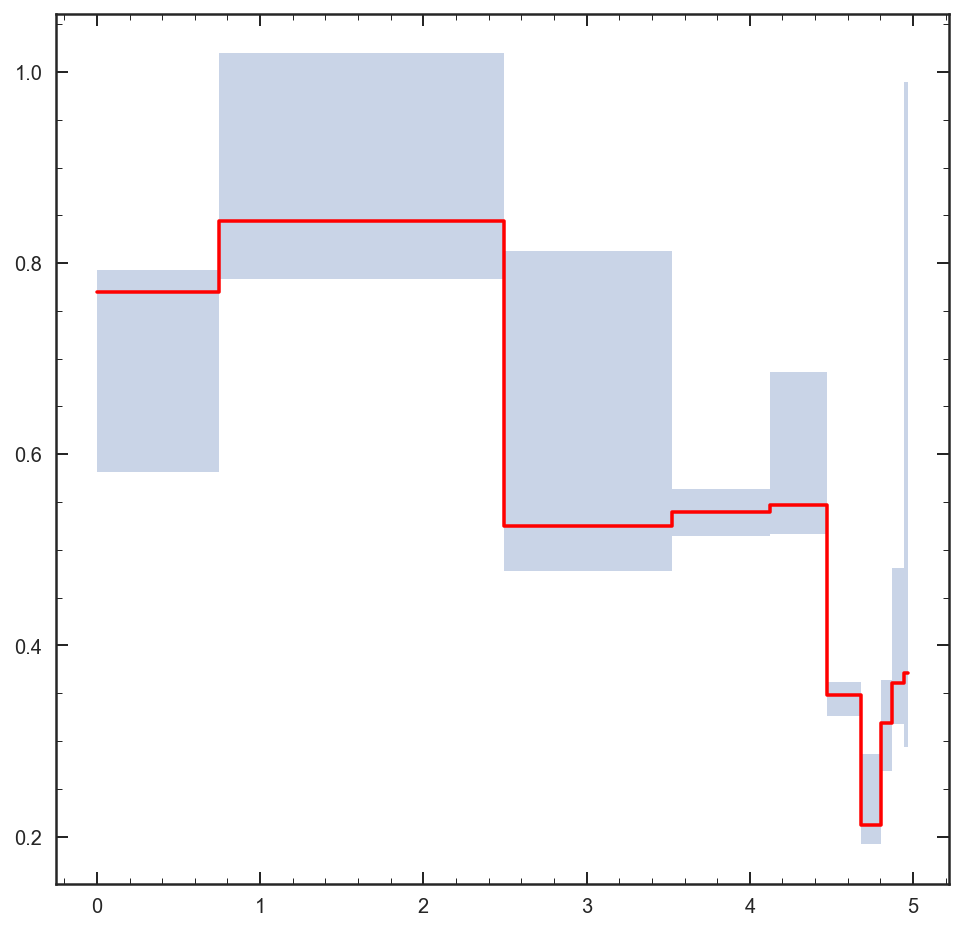

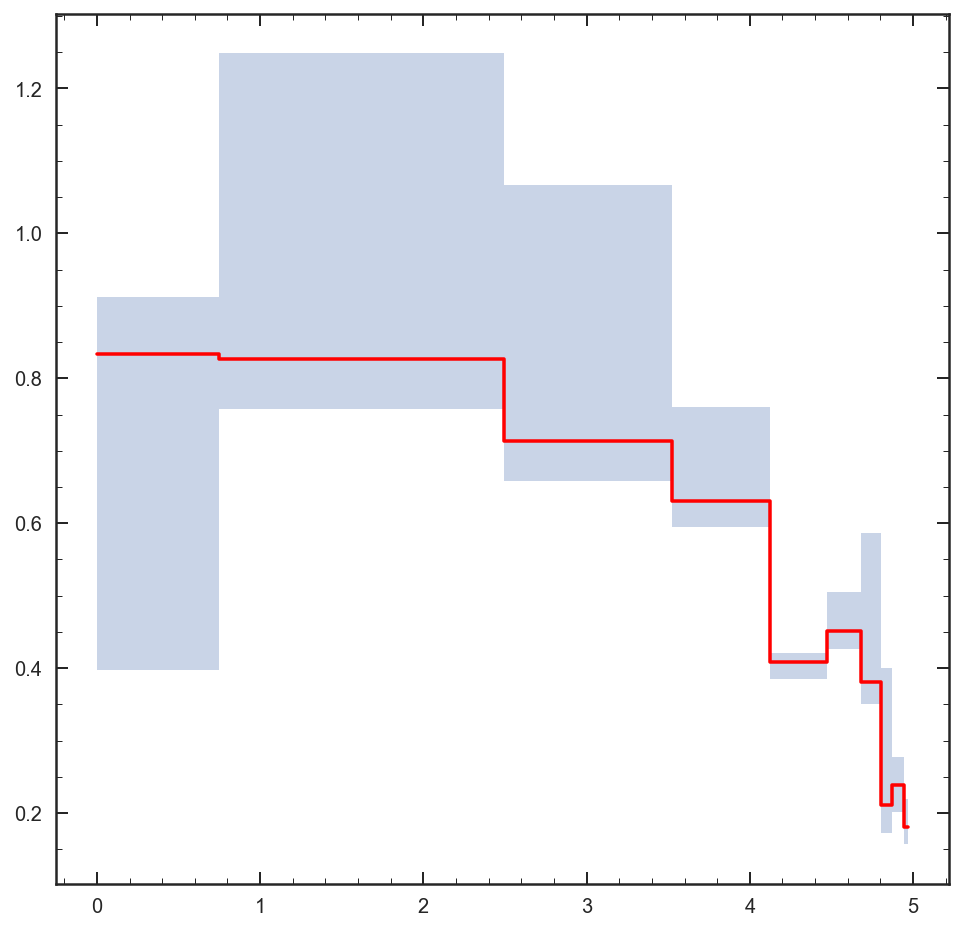

In [77]:
plt.figure(figsize=[8,8])

for i in range(10):
    md = np.zeros(10)
    le = np.zeros(10)
    he = np.zeros(10)

    for ii in range(10):
        t,pt = np.load('../data/posteriors/sim_test_delay_to_tab_continuity_prior_multi_metal_{0}_Pm{1}.npy'.format(i+1,ii+1))
    
        md[ii], le[ii], he[ii] = Highest_density_region(pt,t)

    plt.figure(figsize=[8,8])
    plt.step(np.append(0,LBT), np.append(md[0],md), 'r')
    plt.fill_between(np.append(0,LBT),np.append(md[0],md) - np.append(le[0],le),
                     np.append(md[0],md) + np.append(he[0],he), step = 'pre',alpha = .3)

In [57]:
lages = [0,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9]

tuniv = Oldest_galaxy(specz)
nbins = len(lages) - 1

tbinmax = (tuniv * 0.85) * 1e9
lim1, lim2 = 7.4772, 8.0
agelims = [0,lim1] + np.linspace(lim2,np.log10(tbinmax),nbins-2).tolist() + [np.log10(tuniv*1e9)]
agebins = np.array([agelims[:-1], agelims[1:]]).T

In [19]:
Zsampl = np.random.rand(10)
stdZ = (0.03 * Zsampl) / 0.019
logZ = stats.t.ppf( q = Zsampl, loc = 0, scale = 0.2, df =2.)

In [78]:
def logZ_to_zratio(logZ = None, agebins=None):
    nbins = agebins.shape[0] 
    Zratios = 10**np.clip(logZ,-1,1) # clip maximum and minimum values
    coeffs = np.array([ (1. / np.prod(Zratios[:i])) for i in range(nbins)])

    return coeffs  / coeffs.sum() * 0.25 /0.019 

In [79]:
tst = logZ_to_zratio(logZ,agebins)[::-1]

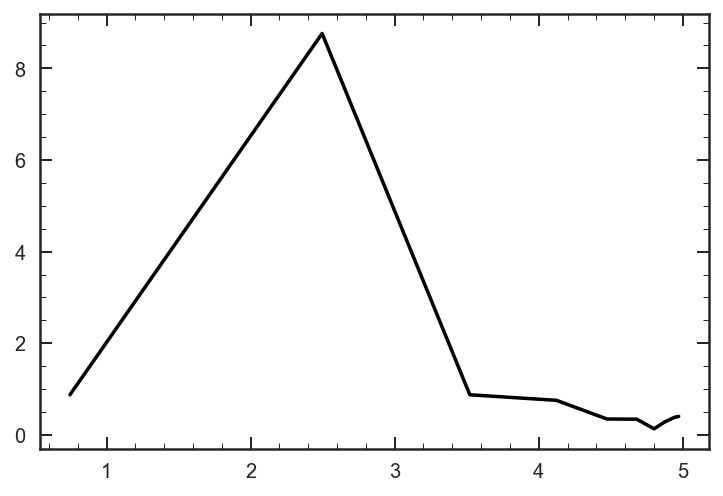

In [80]:
# plt.plot(LBT, stdZ)
# plt.plot(LBT, Zratios,'r')
plt.plot(LBT, tst,'k')
# plt.ylim(0.002 / 0.019, 0.03 / 0.019)

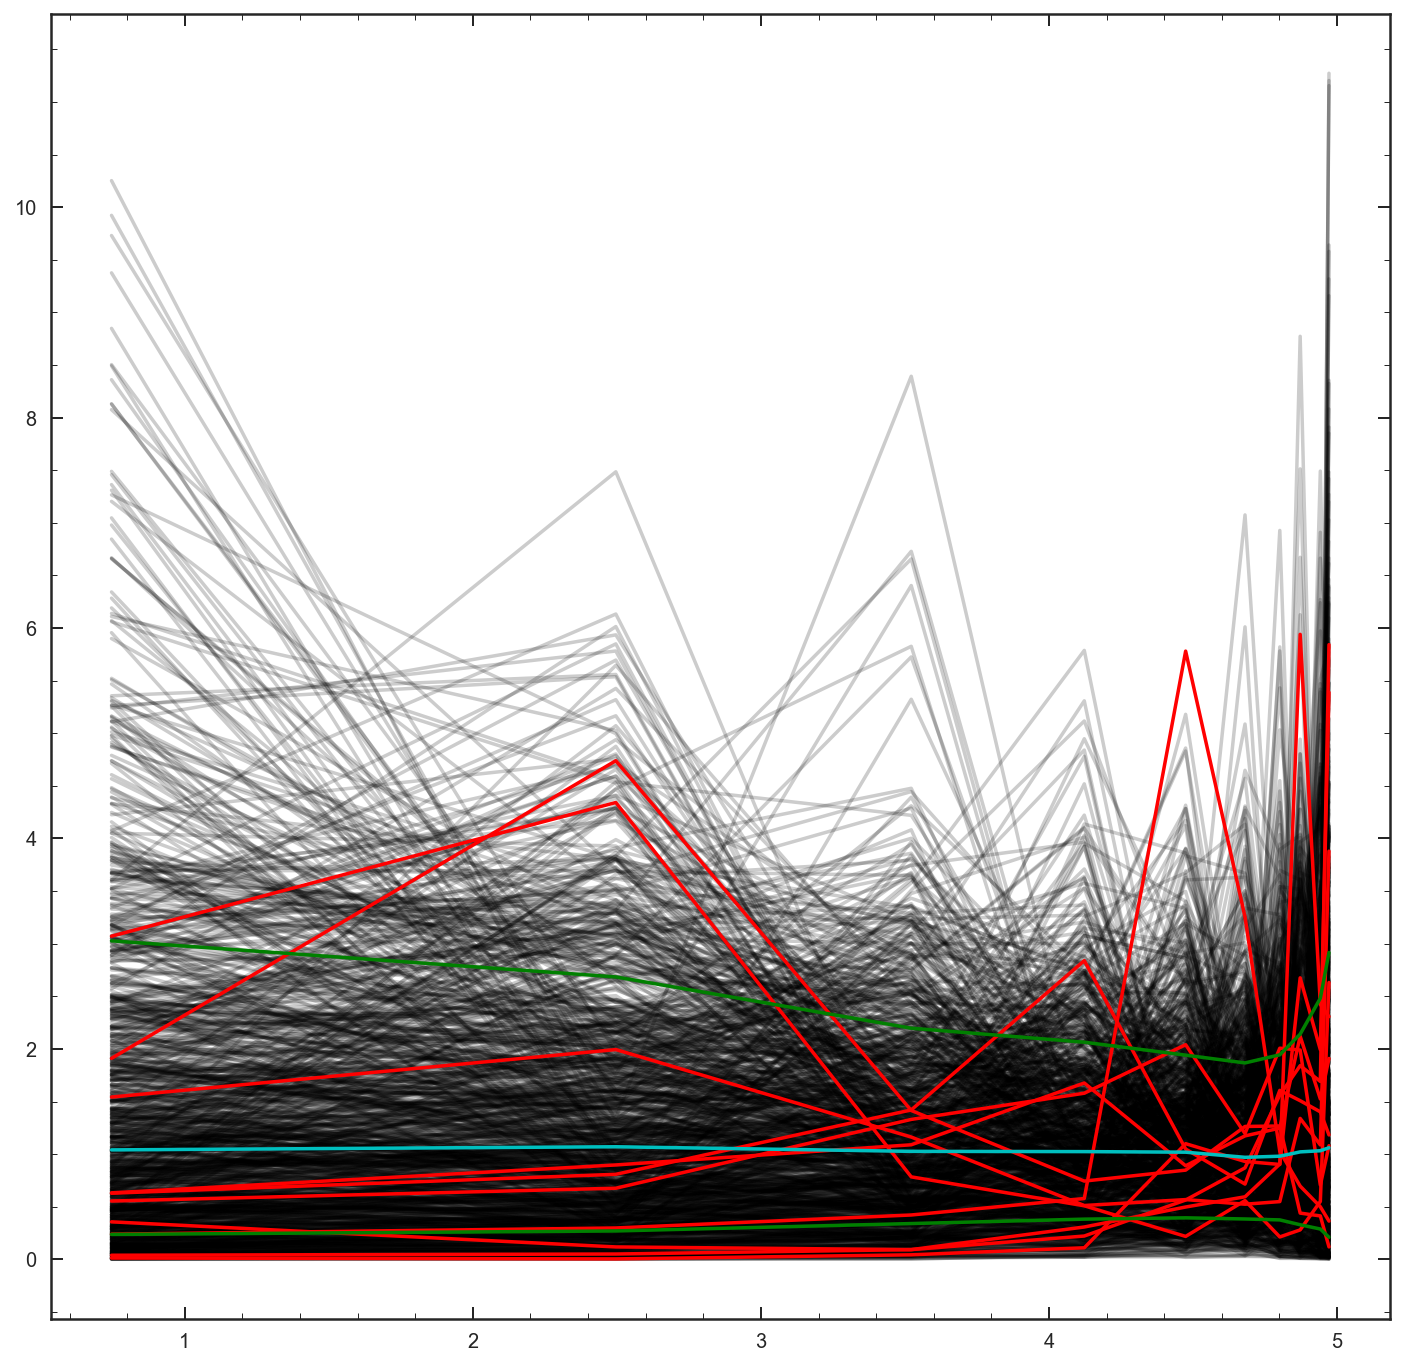

In [83]:
sampl_grid = np.zeros([len(tst),1000])


plt.figure(figsize=[12,12])

for i in range(1000):
    Zsampl = np.random.rand(10)
    logZ = stats.t.ppf( q = Zsampl, loc = 0, scale = 0.2, df =2.)
    
    tst = logZ_to_zratio(logZ,agebins)[::-1]
    sampl_grid.T[i] = tst
    plt.plot(LBT, tst,'k', alpha = 0.2)
for i in range(10):
    Zsampl = np.random.rand(10)
    logZ = stats.t.ppf( q = Zsampl, loc = 0, scale = 0.2, df =2.)
    
    tst = logZ_to_zratio(logZ,agebins)[::-1]
    plt.plot(LBT, tst,'r')
    
plt.plot(LBT, np.percentile(sampl_grid,50,axis=1),'c')
plt.plot(LBT, np.percentile(sampl_grid,16,axis=1),'g')
plt.plot(LBT, np.percentile(sampl_grid,84,axis=1),'g')

In [82]:
x = np.arange(-1,1,0.001)
Px = stats.t.pdf(x, loc = 0, scale = 0.2, df =2.)
Px2 = stats.t.pdf(x, loc = 0, scale = 0.3, df =2.)

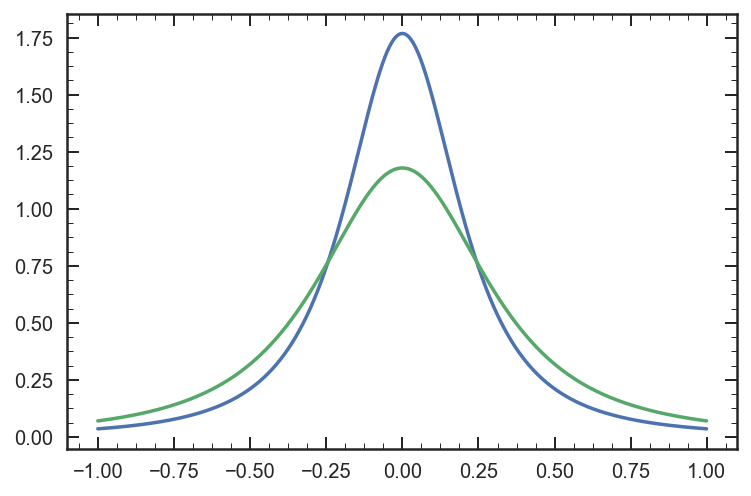

In [100]:
plt.plot(x,Px)
plt.plot(x,Px2)

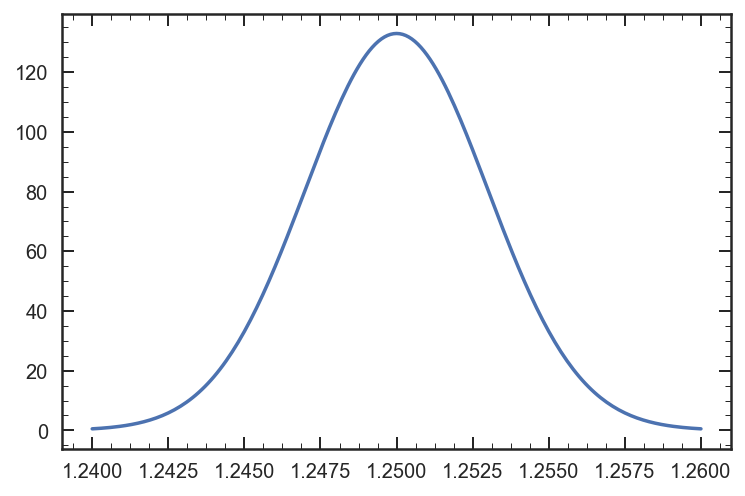

In [175]:
x = np.arange(1.24,1.26,0.0001)

plt.plot(x,stats.norm.pdf(x,loc = specz, scale = 0.003))


In [178]:
z= stats.norm.ppf(np.random.rand(1),loc = 10.75, scale = 0.5)

In [191]:
dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_multi_metal_6.npy').item()

(<Figure size 864x5184 with 48 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a68a0d0b8>,
       dtype=object))

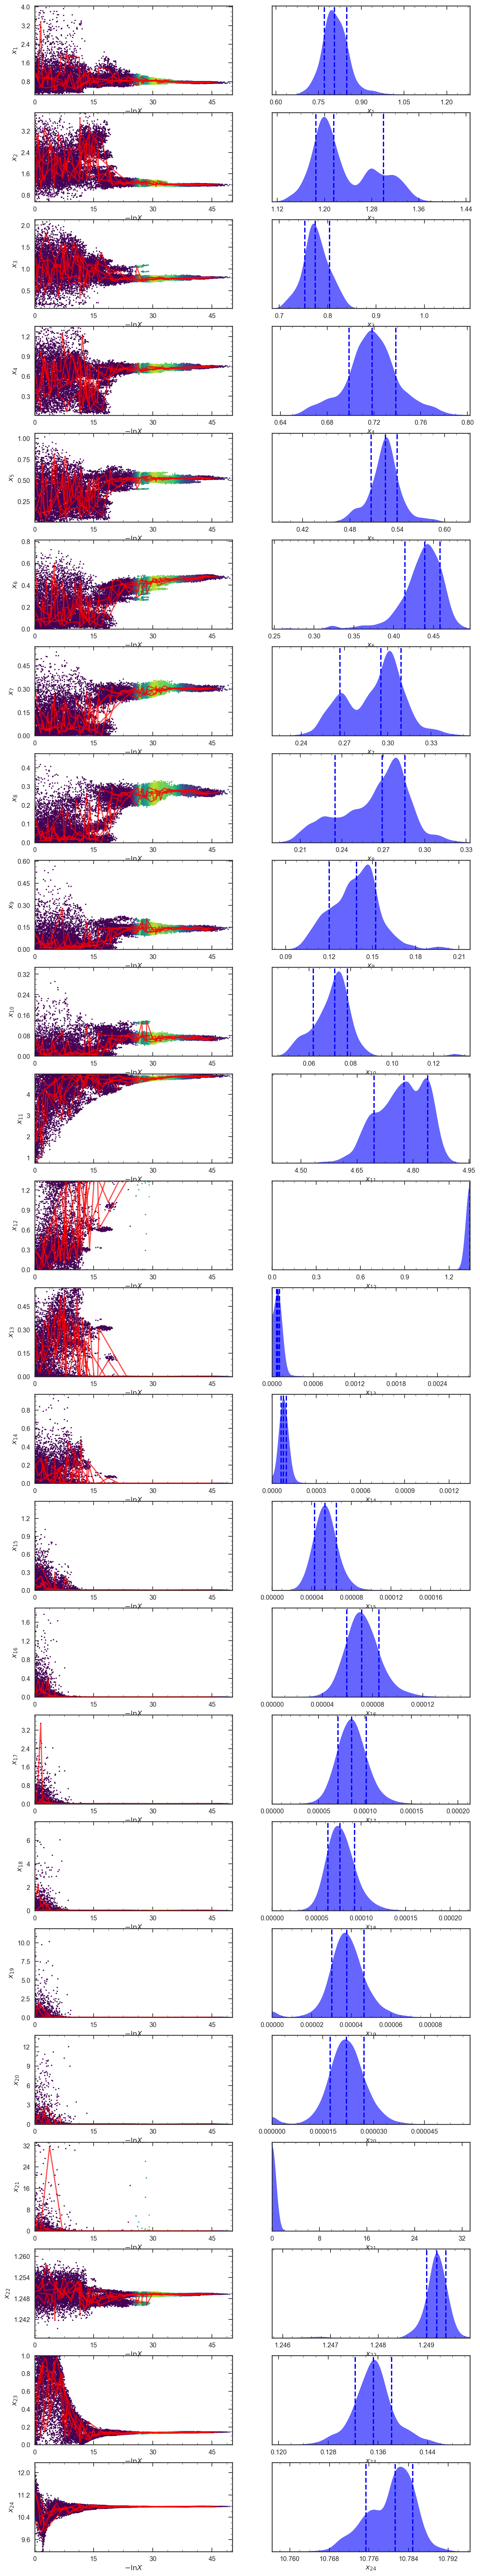

In [192]:
dyplot.traceplot(dres, truths=None, truth_color='black',
                             show_titles=False, title_kwargs={'fontsize': 5, 'y': 1.05},
                             trace_cmap='viridis', kde=False,
                             connect=True, connect_highlight=range(5))

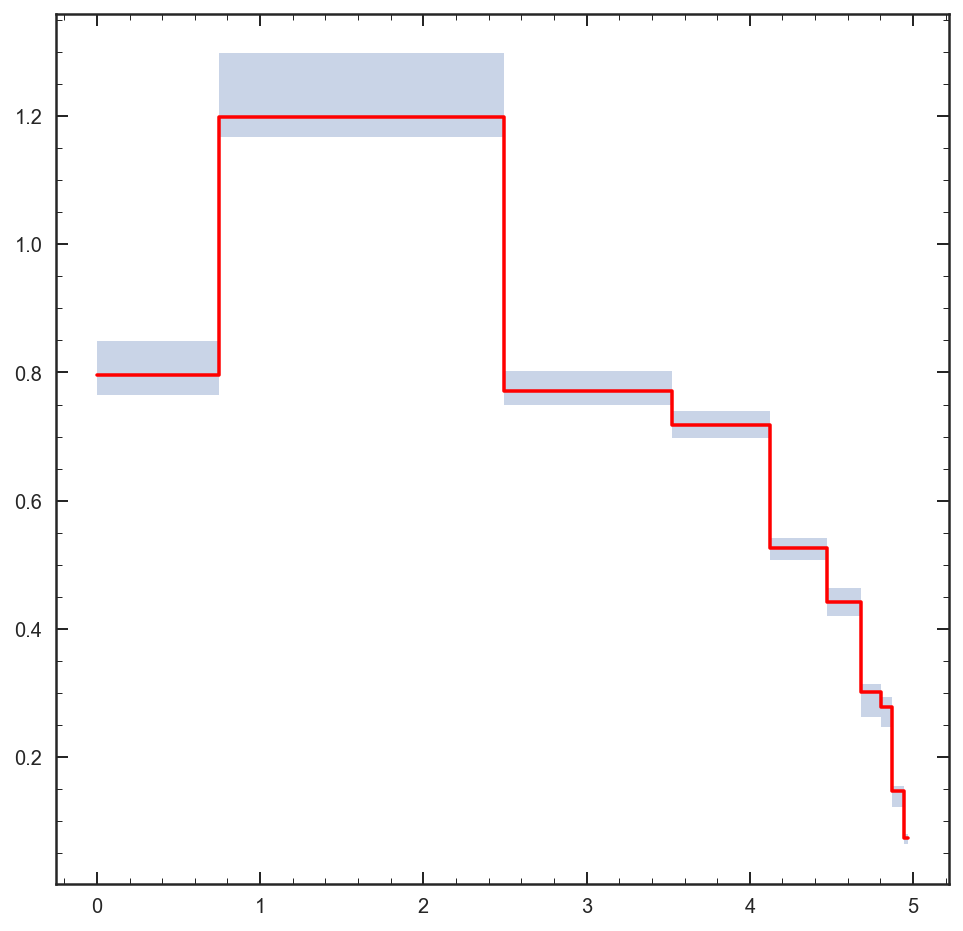

In [193]:
md = np.zeros(10)
le = np.zeros(10)
he = np.zeros(10)

for ii in range(10):
    t,pt = Get_posterior(dres.samples[:,ii],dres.logwt,dres.logz)
    md[ii], le[ii], he[ii] = Highest_density_region(pt,t)

plt.figure(figsize=[8,8])
plt.step(np.append(0,LBT), np.append(md[0],md), 'r')
plt.fill_between(np.append(0,LBT),np.append(md[0],md) - np.append(le[0],le),
                 np.append(md[0],md) + np.append(he[0],he), step = 'pre',alpha = .3)

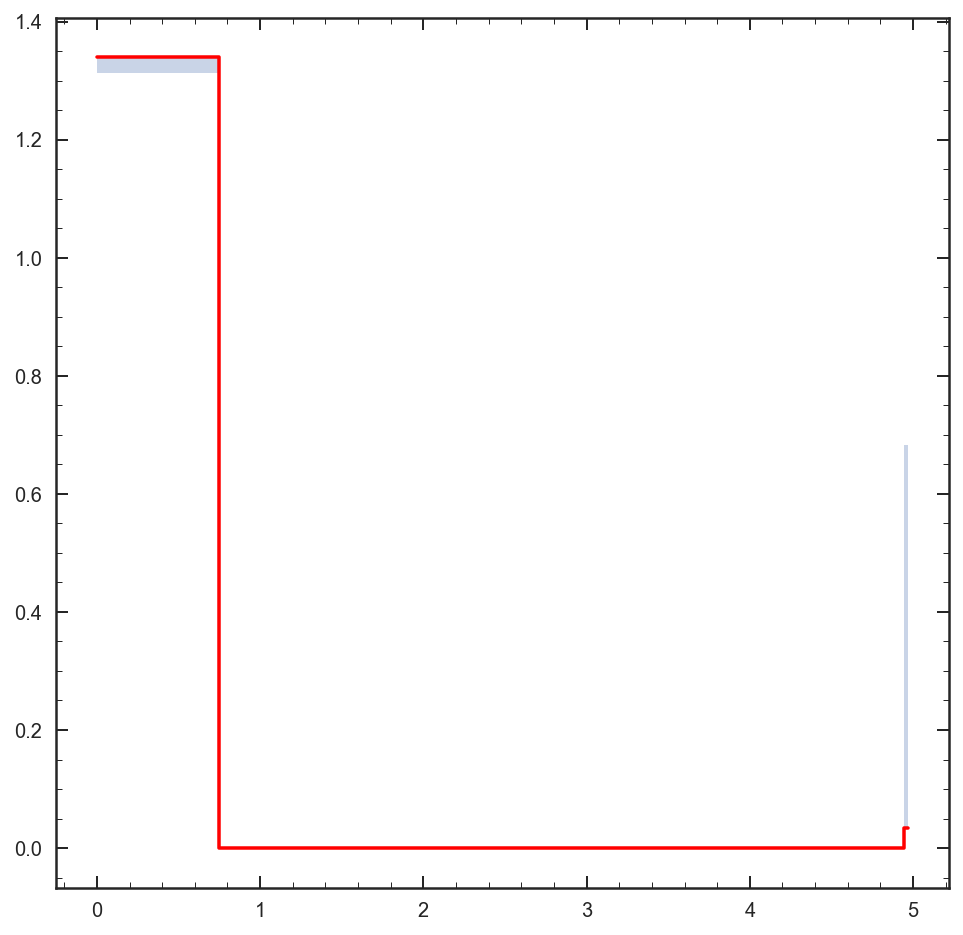

In [202]:
md = np.zeros(10)
le = np.zeros(10)
he = np.zeros(10)

for ii in range(10):
    t,pt = Get_posterior(dres,ii+11)
    md[ii], le[ii], he[ii] = Highest_density_region(pt,t)

plt.figure(figsize=[8,8])
plt.step(np.append(0,LBT), np.append(md[0],md), 'r')
plt.fill_between(np.append(0,LBT),np.append(md[0],md) - np.append(le[0],le),
                 np.append(md[0],md) + np.append(he[0],he), step = 'pre',alpha = .3)

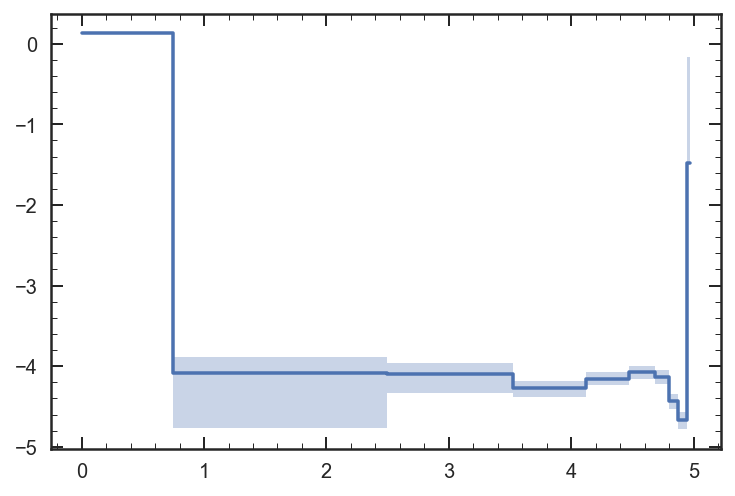

In [195]:
plt.step(np.append(0,LBT), np.log10(np.append(md[0],md)))
plt.fill_between(np.append(0,LBT),np.log10(np.append(md[0],md) - np.append(le[0],le)),
                 np.log10(np.append(md[0],md) + np.append(he[0],he)), step = 'pre',alpha = .3)